# UFC Fight Analysis <a class='tocSkip'>

**By: [Courtney Ferguson Lee](https://www.linkedin.com/in/courtneyfergusonlee/)**

<img src='https://raw.githubusercontent.com/spacecadet84/ufc_fight_analysis/master/images/ufc_fighter_red_wordcloud_small.png'>

The raw Python code used here is turned off by default for easier reading.

In [2]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

# Introduction

What does it mean to be the best fighter in the world? Is it the person with the best kick? The best punch? Or is it something else? This project seeks to determine which factors are the best predictors of success in the UFC. It explores every fight since the organization's inception in the hopes of gaining insight into what separates winners and losers. We start with an exploratory visual analysis of all variables before cleaning the data and building our machine learning models. Currently, the algorithms are able to predict the outcome with approximately ~~55-60%~~ ~~57-66%~~ 85-88% accuracy. Our goal is to improve that over time through iteration.

I was originally inspired by [this kaggle kernel](https://www.kaggle.com/calmdownkarm/ufc-predictor-and-notes) as well as my own background in martial arts growing up. Their model had a peak accuracy between 58-63% and I wanted to see if I could improve upon that. I wrote a new scraper, pulling data from fightmetric.com instead of ufc.com, spent more time on exploratory analysis and maintained a smaller overall feature set. That last point especially helped me overcome the curse of dimensionality problem and reach a peak accuracy of 88%.

# Background

The Ultimate Fighting Championship (UFC) is a mixed martial arts fighting organization based out of Las Vegas, Nevada. Founded in 1992, it's original goal was to pit fighters from around the world against each other to see which fighting style was the best. In the beginning, there were no rules and there were no weight classes. Eye gouges, groin strikes, headbutts and biting were all legal. Fighters weighing 160 lbs would get tossed in against 400 lbs behemoths. This type of no holds bar contest had never been attempted before and it quickly gained notoriety for its brutality.

It also gave rise to a new way of thinking about fighting. When kung-fu masters, boxers, kickboxers, and karate experts all met for the first time, no one could have predicted the outcome. Most people expected the larger, stronger fighters to win. On the contrary, it was an unassuming 178 pound man named Royce Gracie who would go on to win the first contest. What was even stranger was that no one could explain how he won the first time (or the second or the third). He didn't pummel his opponent into submission as expected, but instead locked him up using wrestling moves most people hadn't seen before. This was the world's introduction to Brazillian Jiu Jitsu (BJJ).

After Royce went on to win several UFC contests, people began to realize he was not just getting lucky. Fighters started studying this martial art so they could start applying these techniques in their matches or at the very least prevent themselves from being submitted by Royce. Then, they started adding techniques from other fighting styles so that they, too could become the best in the world. This was the beginning of mixed martial arts or MMA. It started out with dozens of different styles, but a handful started to show up repeatedly: BJJ, wrestling, boxing and kickboxing. Over time, fighters' skill in these 4 areas evolved to where no one art was able to completely dominate the others. 

Now, the UFC is watched by millions worldwide and its support continues to grow. The rules were changed to protect the safety of the fighters. You can no longer gouge your opponent's eyes or pull hair or bite. All fighters are now required to wear standard MMA gloves and shoes are no longer allowed in the octagon. There are now weight classes that range from 115 lbs all the way up to 265. A lot has changed in the UFC and this project seeks to determine which components matter most in a match.

<img src='https://cdn.rawgit.com/spacecadet84/ufc_fight_analysis/bcb906d3/images/ufc_red_wordcloud.pnghttps://raw.githubusercontent.com/spacecadet84/ufc_fight_analysis/master/images/ufc_red_wordcloud_small.png'>

# Data

The data was scraped from www.fightmetrics.com with Beautiful Soup in two stages. The first script compiled a list of event urls and wrote them to a CSV. The second script crawled through those urls and extracted all available fight data into a pandas dataframe. There are 31 features and 8624 records.

During our exploration, we'll examine the data from several perspectives. We'll put it under a microscope through univariate analysis, get a bird's eye view using a correlation matrix and view it from ringside through multivariate analysis.

In [1]:
# Noteboook Functionality
import warnings
warnings.filterwarnings('ignore')

# Linear Algebra
import pandas as pd
pd.options.display.max_columns = 50
pd.options.display.max_colwidth = 75
from IPython.display import display
import numpy as np
from pprint import pprint
from scipy.stats import norm
import random
from datetime import datetime

# Visualizations
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("white")
colors = sns.color_palette()
from plotnine import *
from plotnine.data import *
from mizani.breaks import date_breaks
from mizani.formatters import date_format
import skmisc
from PIL import Image
from wordcloud import WordCloud
import branca
import folium

#SciKit Learn Models
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report, confusion_matrix
from sklearn.preprocessing import MinMaxScaler

fight_data = pd.read_csv("data/fights_v5.csv")
fight_df = pd.DataFrame(fight_data)

In [2]:
fight_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8624 entries, 0 to 8623
Data columns (total 31 columns):
body                 8624 non-null int64
body_attempts        8624 non-null int64
clinch               8624 non-null int64
clinch_attempts      8624 non-null int64
date                 8624 non-null object
distance             8624 non-null int64
distance_attempts    8624 non-null int64
fight_id             8624 non-null int64
ground               8624 non-null int64
ground_attempts      8624 non-null int64
head                 8624 non-null int64
head_attempts        8624 non-null int64
kd                   8624 non-null int64
leg                  8624 non-null int64
leg_attempts         8624 non-null int64
location             8624 non-null object
method               8624 non-null object
name                 8624 non-null object
pass                 8624 non-null int64
referee              8590 non-null object
reversals            8624 non-null int64
round                8624 n

From this, we can see that we have a total of 32 Columns and one dependent variable. The columns themselves have 7 object types (First Name, Last Name, Method, Referee, Date, Location and Title), and 24 int types. This however does not give us a complete picture of the data, so we'll use a few other pandas functions to get a better glimpse. 

In [3]:
fight_df.describe(include=['O'])

,date,location,method,name,referee,title,win/loss
count,8624,8624,8624,8624,8590,8624,8624
unique,407,136,8,1684,155,411,4
top,"November 19, 2016","Las Vegas, Nevada, USA",Decision,Michael Bisping,Herb Dean,UFC Fight Night: Belfort vs Henderson,W
freq,50,2226,3732,27,1292,48,4237


In [4]:
fight_df.describe()

,body,body_attempts,clinch,clinch_attempts,distance,distance_attempts,fight_id,ground,ground_attempts,head,head_attempts,kd,leg,leg_attempts,pass,reversals,round,sig_attempts,sig_strikes,strike_attempts,strikes,sub_attempts,takedowns,td_attempts
count,8624.000000,8624.000000,8624.000000,8624.000000,8624.000000,8624.000000,8624.000000,8624.000000,8624.000000,8624.000000,8624.000000,8624.000000,8624.000000,8624.000000,8624.000000,8624.000000,8624.000000,8624.000000,8624.000000,8624.000000,8624.000000,8624.000000,8624.000000,8624.000000
mean,5.952690,8.695965,5.202922,7.795339,19.456401,54.530380,2156.117115,5.200023,7.826647,19.006841,55.245014,0.213590,4.899814,6.211387,1.140306,0.139842,2.261596,70.152365,29.859346,91.316674,48.747333,0.458372,1.097750,2.843576
std,7.149103,10.056715,7.555530,10.664296,22.512320,58.549299,1245.879529,9.048582,13.412923,18.760367,51.534880,0.489548,6.817100,8.500463,2.057287,0.426066,1.006637,62.590131,26.801767,72.408181,41.610023,0.914472,1.697957,3.696537
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,2.000000,0.000000,1.000000,3.000000,11.000000,1077.750000,0.000000,0.000000,5.000000,16.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,22.000000,9.000000,31.000000,16.000000,0.000000,0.000000,0.000000
50%,4.000000,5.000000,2.000000,4.000000,12.000000,34.000000,2155.500000,1.000000,2.000000,14.000000,41.000000,0.000000,2.000000,3.000000,0.000000,0.000000,3.000000,54.000000,23.000000,78.000000,40.000000,0.000000,0.000000,1.000000
75%,9.000000,12.000000,7.000000,11.000000,27.000000,79.000000,3233.250000,7.000000,10.000000,27.000000,79.000000,0.000000,7.000000,8.000000,1.000000,0.000000,3.000000,101.000000,43.000000,136.000000,70.000000,1.000000,2.000000,4.000000
max,92.000000,101.000000,95.000000,115.000000,228.000000,447.000000,4337.000000,100.000000,136.000000,199.000000,400.000000,5.000000,75.000000,89.000000,26.000000,5.000000,5.000000,495.000000,238.000000,497.000000,361.000000,10.000000,21.000000,33.000000


## Observations

Most of the variables have low means and large maximum values, which means they are probably highly skewed to the right. It might make sense to apply a log transform to some of the distributions when conducting the univariate analysis.

In the categorical overview, we can see that Herb Dean is truly a prolific ref! Who knew that he officiated nearly 1300 UFC fights? I would've guessed John McCarthy was the leader in that respect, but Herb Dean has definitely paid his dues. You'll never guess who's the most prolific UFC fighter. Spoler alert: It's Michael Bisping. I bet he wasn't even on your radar.

## Missing Data

Nothing to see here. The only column that has any missing data is the referee column and it's less than 0.4%. Let's keep it moving

In [5]:
percent_missing = (fight_df.isnull().sum()/fight_df.isnull().count()).sort_values()
percent_missing

body                 0.000000
td_attempts          0.000000
takedowns            0.000000
sub_attempts         0.000000
strikes              0.000000
strike_attempts      0.000000
sig_strikes          0.000000
sig_attempts         0.000000
round                0.000000
reversals            0.000000
pass                 0.000000
name                 0.000000
method               0.000000
title                0.000000
location             0.000000
leg                  0.000000
kd                   0.000000
head_attempts        0.000000
head                 0.000000
ground_attempts      0.000000
ground               0.000000
fight_id             0.000000
distance_attempts    0.000000
distance             0.000000
date                 0.000000
clinch_attempts      0.000000
clinch               0.000000
body_attempts        0.000000
leg_attempts         0.000000
win/loss             0.000000
referee              0.003942
dtype: float64

# Minor Aesthetics

Before diving deeper into the dataset, let's take a moment to fix a few minor details.

## Rearranging Columns

It bugs me slightly that each fighter's name is buried in the middle of the dataframe. The analysis will be a lot simpler if that information was the first thing we saw in each row. Let's take care of that and move the date, fight_id, win/loss and method columns to the front as well.

In [6]:
# Creates a copy of the dataframe for testing
fight_df = pd.DataFrame(fight_data.copy())

# Rearranges the columns so the name, date, fight_id, win/loss and method appear first
cols = fight_df.columns.tolist()
cols = cols[17:18] + cols[4:5] + cols[7:8] + cols[-1:] + cols[16:17] + cols[:4] + cols[5:7] + cols[8:16] + cols[18:-1]

fight_df = fight_df[cols]

# Sets the index as the fight_id
# fight_df.set_index('fight_id', inplace=True)

# Change kd to knock_down for readability
fight_df.rename(columns={'kd': 'knockdowns'}, inplace=True)

In [7]:
fight_df.tail()

,name,date,fight_id,win/loss,method,body,body_attempts,clinch,clinch_attempts,distance,distance_attempts,ground,ground_attempts,head,head_attempts,knockdowns,leg,leg_attempts,location,pass,referee,reversals,round,sig_attempts,sig_strikes,strike_attempts,strikes,sub_attempts,takedowns,td_attempts,title
8619,Art Jimmerson,"November 12, 1993",4335,L,Submission,0,0,0,0,0,0,0,0,0,0,0,0,0,"Denver, Colorado, USA",0,Joao Barreto,0,1,0,0,0,0,0,0,0,UFC 1: The Beginning
8620,Kevin Rosier,"November 12, 1993",4336,W,KO/TKO,3,4,4,9,4,10,7,8,12,23,2,0,0,"Denver, Colorado, USA",0,Joao Barreto,0,1,27,15,53,38,0,0,0,UFC 1: The Beginning
8621,Zane Frazier,"November 12, 1993",4336,L,KO/TKO,3,6,10,19,0,7,2,2,7,19,0,2,3,"Denver, Colorado, USA",0,Joao Barreto,0,1,28,12,29,13,0,0,0,UFC 1: The Beginning
8622,Gerard Gordeau,"November 12, 1993",4337,W,KO/TKO,0,0,0,0,1,3,2,2,3,5,0,0,0,"Denver, Colorado, USA",0,Joao Barreto,0,1,5,3,5,3,0,0,0,UFC 1: The Beginning
8623,Teila Tuli,"November 12, 1993",4337,L,KO/TKO,0,0,0,0,0,1,0,0,0,1,0,0,0,"Denver, Colorado, USA",0,Joao Barreto,0,1,1,0,1,0,0,0,1,UFC 1: The Beginning


## Rearranging Fights in Chronological Order

Right off the bat I can see the data is organized in reverse-chronological order. Art Jimmerson fought in the first UFC event and I still remember him because he fought with one boxing glove. It was a crazy time... I'll reverse the dataframe so it's in chronological order and re-index the records. 

I'm surprised by the lack of NaN values in this dataset. Apparently, Fightmetrics is very organized! I'll have to crawl deep to see if there are any inconsistencies.

In [8]:
fight_df['fight_id'] = abs(4337 - fight_df['fight_id'])
fight_df = fight_df[::-1]
index = list(range(len(fight_df)))
fight_df.index = index
fight_df['outcome'] = 0
fight_df.loc[fight_df['win/loss'] == 'W', 'outcome'] = 1

Let's format the date column as datetime objects and convert fight_id as a categorical variable while we're at it.

In [9]:
fight_df.loc[:, 'date'] = pd.to_datetime(fight_df.date)
fight_df['fight_id'] = pd.Categorical(fight_df['fight_id'])
all_fights = fight_df.copy()
fight_df.head()

,name,date,fight_id,win/loss,method,body,body_attempts,clinch,clinch_attempts,distance,distance_attempts,ground,ground_attempts,head,head_attempts,knockdowns,leg,leg_attempts,location,pass,referee,reversals,round,sig_attempts,sig_strikes,strike_attempts,strikes,sub_attempts,takedowns,td_attempts,title,outcome
0,Teila Tuli,1993-11-12,0,L,KO/TKO,0,0,0,0,0,1,0,0,0,1,0,0,0,"Denver, Colorado, USA",0,Joao Barreto,0,1,1,0,1,0,0,0,1,UFC 1: The Beginning,0
1,Gerard Gordeau,1993-11-12,0,W,KO/TKO,0,0,0,0,1,3,2,2,3,5,0,0,0,"Denver, Colorado, USA",0,Joao Barreto,0,1,5,3,5,3,0,0,0,UFC 1: The Beginning,1
2,Zane Frazier,1993-11-12,1,L,KO/TKO,3,6,10,19,0,7,2,2,7,19,0,2,3,"Denver, Colorado, USA",0,Joao Barreto,0,1,28,12,29,13,0,0,0,UFC 1: The Beginning,0
3,Kevin Rosier,1993-11-12,1,W,KO/TKO,3,4,4,9,4,10,7,8,12,23,2,0,0,"Denver, Colorado, USA",0,Joao Barreto,0,1,27,15,53,38,0,0,0,UFC 1: The Beginning,1
4,Art Jimmerson,1993-11-12,2,L,Submission,0,0,0,0,0,0,0,0,0,0,0,0,0,"Denver, Colorado, USA",0,Joao Barreto,0,1,0,0,0,0,0,0,0,UFC 1: The Beginning,0


Ah, much better! The earliest fights are at the beginning of the dataset and the later fights are at the end.

## Formatting Locations

Finally, it looks like some of the locations are not formatted uniformly. We'll standardize them and separate the cities, states and countries into separate columns.

In [10]:
locations = sorted(fight_df['location'].unique())

In [11]:
locations_dict = {
    'location': {
        'Berlin, Germany': 'Berlin, Berlin, Germany',
        'Chiba, Japan': 'Chiba, Chiba, Japan',
        'Rio de Janeiro, Brazil': 'Rio de Janeiro, Rio de Janeiro, Brazil',
        'Saitama, Japan': 'Saitama, Saitama, Japan',
        'Sao Paulo, Brazil': 'Sao Paulo, Sao Paulo, Brazil',
        'Singapore, Singapore': 'Marina Bay, Singapore',
        'Tokyo, Japan': 'Tokyo, Tokyo, Japan',
    }
}

updated_locations = fight_df.replace(locations_dict)
#sorted(updated_locations['location'].unique())
updated_locations['city'] = updated_locations.location.str.split(', ').str.get(0)
updated_locations['state'] = updated_locations.location.str.split(',').str.get(1)
updated_locations['country'] = updated_locations.location.str.split(',').str.get(-1)
updated_locations.to_csv('data/updated_locations.csv')

# Variables

In this section, we'll use visualizations to get a clearer picture of the fight data. There are 32 variables at play here, so we'll keep it brief here and go into more depth in the multivariate section.

## Fight Metadata

To start, we'll analyze data that is not specific to individual fighters, but to UFC fights in general. We'll examine the average number of rounds per fight, method used and decision outcome. Let's dive in!

### Rounds

How are the rounds are distributed? Do most fights go the distance or do they usually end early? The maximum number of rounds for each fight depends on the type of fight. Title fights are 5 rounds long while non-title fights are 3 rounds long.

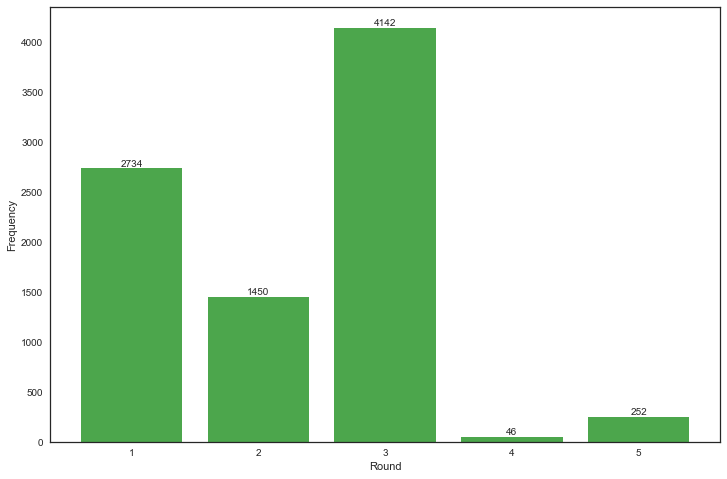

In [12]:
counts = fight_df['round'].value_counts()
plt.figure(figsize=(12,8))
plt.bar(counts.index, counts.values, alpha=.7, color='g')
plt.xlabel('Round')
plt.ylabel('Frequency')
for x,y in zip(counts.index, counts.values):
    plt.text(x, y, y, ha='center', va='bottom')
plt.show()

Very interesting. The most frequent fight length was 3 rounds while the least frequent was 4. This tells me that most title fights go to a decision (5:1 ratio), but non-title fights are pretty evenly split between KO's, injury stoppages and submission.

### Method and Win/Loss

In [13]:
fight_df['method'].value_counts()

Decision      3732
KO/TKO        2790
Submission    1850
TKO            130
Overturned      68
Could           26
DQ              24
Other            4
Name: method, dtype: int64

The "TKO", "Could" and "Other" immedietely jump out at me as categories worth exploring. I have no idea what the "Could" or "Other" categories represent. I'm guessing the first is a typo but I'll have to do some research to see what's going on there. I'm also curious as to why they placed KO/TKO and TKO into separate groups. I'll have to research that as well to see if we can consolidate the two categories.

In [14]:
display(fight_df[fight_df.method=='Could'].tail(2))
display(fight_df[fight_df.method=='Other'].tail(2))
display(fight_df[fight_df.method=='TKO'].tail(2))

,name,date,fight_id,win/loss,method,body,body_attempts,clinch,clinch_attempts,distance,distance_attempts,ground,ground_attempts,head,head_attempts,knockdowns,leg,leg_attempts,location,pass,referee,reversals,round,sig_attempts,sig_strikes,strike_attempts,strikes,sub_attempts,takedowns,td_attempts,title,outcome
8264,Dustin Poirier,2017-05-13,4158,NC,Could,7,11,12,17,61,127,0,0,61,128,0,5,5,"Dallas, Texas, USA",0,Herb Dean,0,2,144,73,150,79,2,0,0,UFC 211: Miocic vs. Dos Santos,0
8265,Eddie Alvarez,2017-05-13,4158,NC,Could,11,13,5,12,36,112,3,3,32,111,0,1,3,"Dallas, Texas, USA",0,Herb Dean,0,2,127,44,128,44,0,1,4,UFC 211: Miocic vs. Dos Santos,0


,name,date,fight_id,win/loss,method,body,body_attempts,clinch,clinch_attempts,distance,distance_attempts,ground,ground_attempts,head,head_attempts,knockdowns,leg,leg_attempts,location,pass,referee,reversals,round,sig_attempts,sig_strikes,strike_attempts,strikes,sub_attempts,takedowns,td_attempts,title,outcome
122,Oleg Taktarov,1995-09-08,68,D,Other,0,1,1,4,3,18,0,0,3,17,0,1,4,"Buffalo, New York, USA",0,John McCarthy,0,2,22,4,128,110,0,0,2,UFC 7: The Brawl in Buffalo,0
123,Ken Shamrock,1995-09-08,68,D,Other,2,4,4,6,8,29,17,23,26,53,0,1,1,"Buffalo, New York, USA",1,John McCarthy,0,2,58,29,222,180,1,1,1,UFC 7: The Brawl in Buffalo,0


,name,date,fight_id,win/loss,method,body,body_attempts,clinch,clinch_attempts,distance,distance_attempts,ground,ground_attempts,head,head_attempts,knockdowns,leg,leg_attempts,location,pass,referee,reversals,round,sig_attempts,sig_strikes,strike_attempts,strikes,sub_attempts,takedowns,td_attempts,title,outcome
8356,Rolando Dy,2017-06-17,4204,L,TKO,5,12,1,5,19,60,0,0,9,44,0,6,9,"Kallang, Singapore",1,Neil Swailes,0,2,65,20,66,21,0,1,4,UFC Fight Night: Holm vs. Correia,0
8357,Alex Caceres,2017-06-17,4204,W,TKO,10,14,5,11,42,76,4,6,38,75,1,3,4,"Kallang, Singapore",1,Neil Swailes,0,2,93,51,99,56,1,0,0,UFC Fight Night: Holm vs. Correia,1


After doing a little market research and totally not wasting time by watching UFC fights, it looks like the "Could" category stands for no contest, "Other" stands for draws and "TKO" stands for fights where one fighter could not continue due to injury. Each of these scenarios present different challenges. Before going further, let's change "Could" to "No Contest", "Other" to "Draw" and change TKO to "Injury".

In [15]:
fight_df.loc[fight_df.method=='Could', 'method'] = "No Contest"
fight_df.loc[fight_df.method=='TKO', "method"] = "Injury"
fight_df.loc[fight_df.method=='Other', "method"] = "Draw"

Fights that stop due to injury are usually fights in which one fighter has been beating his opponent so badly, they had to stop the fight because the opponent couldn't continue. I'll probably do some more market research later, but right now I see that as a win. The goal is to defeat the other fighter, so mission accomplished. I don't know if I'll combine that category with TKO/KO's, but it's a valid win.

No contests and draws, however are a different story. A no contest could result from a fighter using an illegal technique or getting popped for doping or a mulitude of other reasons and a draw is such an insignificant anomaly that it doesn't warrant further investigation. Neither category demonstrates that one side dominated the other and in many cases they are the result of luck. Because of this, they will most likely be dropped from the dataset before building any models.

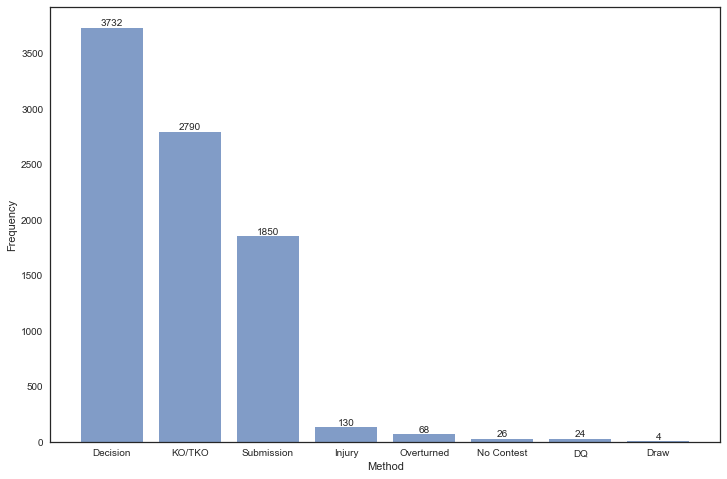

In [16]:
counts = fight_df['method'].value_counts()
plt.figure(figsize=(12,8))
plt.bar(range(len(counts.index)), counts.values, alpha=.7)
plt.xlabel('Method')
plt.ylabel('Frequency')
plt.xticks(range(len(counts.index)), counts.index)
for x,y in zip(range(len(counts.index)), counts.values):
    plt.text(x, y, y, ha='center', va='bottom')
plt.show()

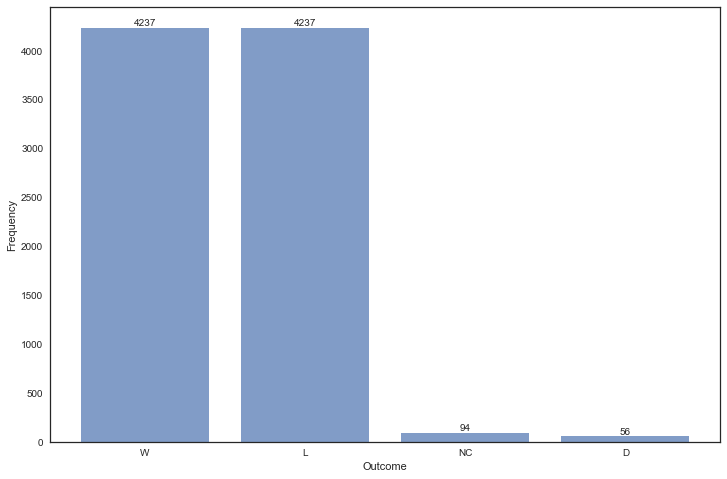

In [17]:
counts = fight_df['win/loss'].value_counts()
plt.figure(figsize=(12,8))
plt.bar(range(len(counts.index)), counts.values, alpha=.7)
plt.xlabel('Outcome')
plt.ylabel('Frequency')
plt.xticks(range(len(counts.index)), counts.index)
for x,y in zip(range(len(counts.index)), counts.values):
    plt.text(x, y, y, ha='center', va='bottom')
plt.show()

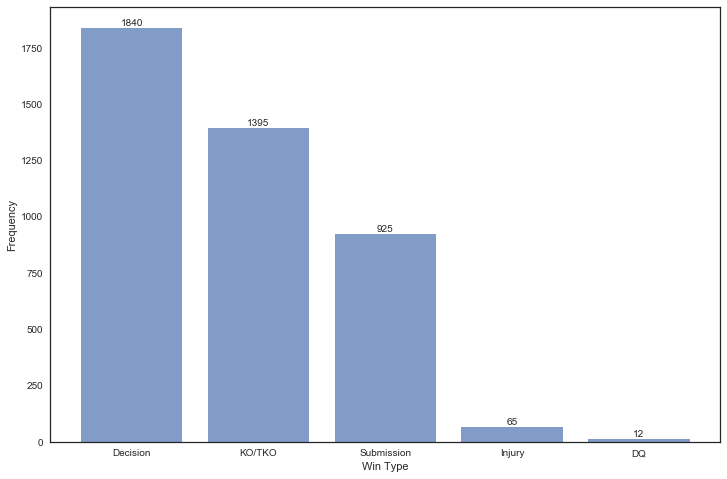

In [18]:
counts = fight_df[fight_df['win/loss']=='W'].method.value_counts()
plt.figure(figsize=(12,8))
plt.bar(range(len(counts.index)), counts.values, alpha=.7)
plt.xlabel('Win Type')
plt.ylabel('Frequency')
plt.xticks(range(len(counts.index)), counts.index)
for x,y in zip(range(len(counts.index)), counts.values):
    plt.text(x, y, y, ha='center', va='bottom')
plt.show()

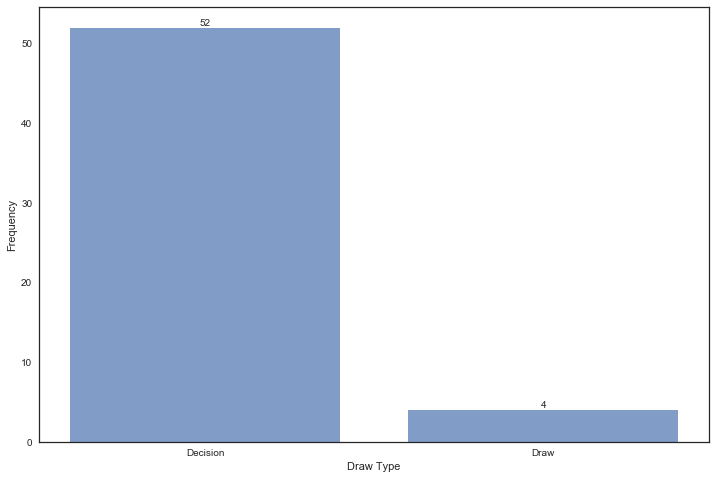

In [19]:
counts = fight_df[fight_df['win/loss']=='D'].method.value_counts()
plt.figure(figsize=(12,8))
plt.bar(range(len(counts.index)), counts.values, alpha=.7)
plt.xlabel('Draw Type')
plt.ylabel('Frequency')
plt.xticks(range(len(counts.index)), counts.index)
for x,y in zip(range(len(counts.index)), counts.values):
    plt.text(x, y, y, ha='center', va='bottom')
plt.show()

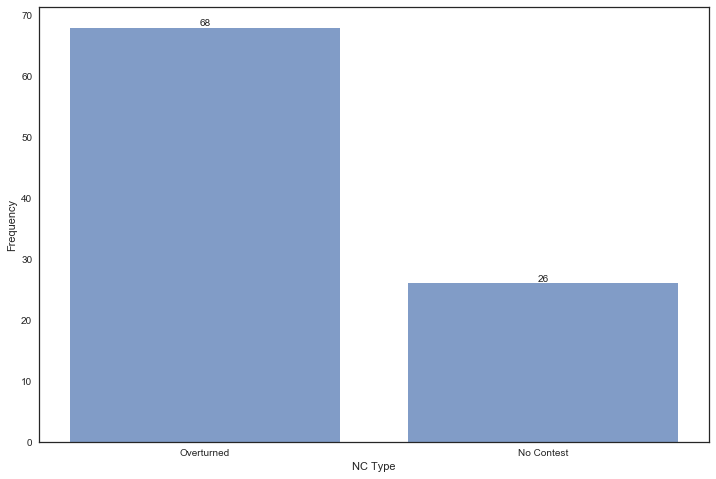

In [20]:
counts = fight_df[fight_df['win/loss']=='NC'].method.value_counts()
plt.figure(figsize=(12,8))
plt.bar(range(len(counts.index)), counts.values, alpha=.7)
plt.xlabel('NC Type')
plt.ylabel('Frequency')
plt.xticks(range(len(counts.index)), counts.index)
for x,y in zip(range(len(counts.index)), counts.values):
    plt.text(x, y, y, ha='center', va='bottom')
plt.show()

### Clean Wins

Let's restrict our view to wins that result from one of the following: 
1. Judge's Decision
2. KO/TKO
3. Submission
4. Injury

These are situations where one fighter was able to prove their dominance over another through their fighting skill. The remaining categories are at best the result of random chance and not relevant to our interests:

1. Overturned
2. No Contest ['method']
3. DQ
4. Draw
5. NC ['win/loss']

If we want to build a classifier that distinguishes between winners and losers, we should look at fights based on factors that are within their control.

In [21]:
fight_df = fight_df[(fight_df['win/loss'] == 'W') | (fight_df['win/loss'] == 'L')]
fight_df = fight_df[(fight_df.method != 'Overturned') & (fight_df.method != 'No Contest') & (fight_df.method != 'DQ')]
fight_df.method.value_counts()

Decision      3680
KO/TKO        2790
Submission    1850
Injury         130
Name: method, dtype: int64

## Heatmap

Let's take a bird's eye view of the data. We'll use a heatmap to spot correlations and make quick inferences about the dataset before diving into the individual fight variables.

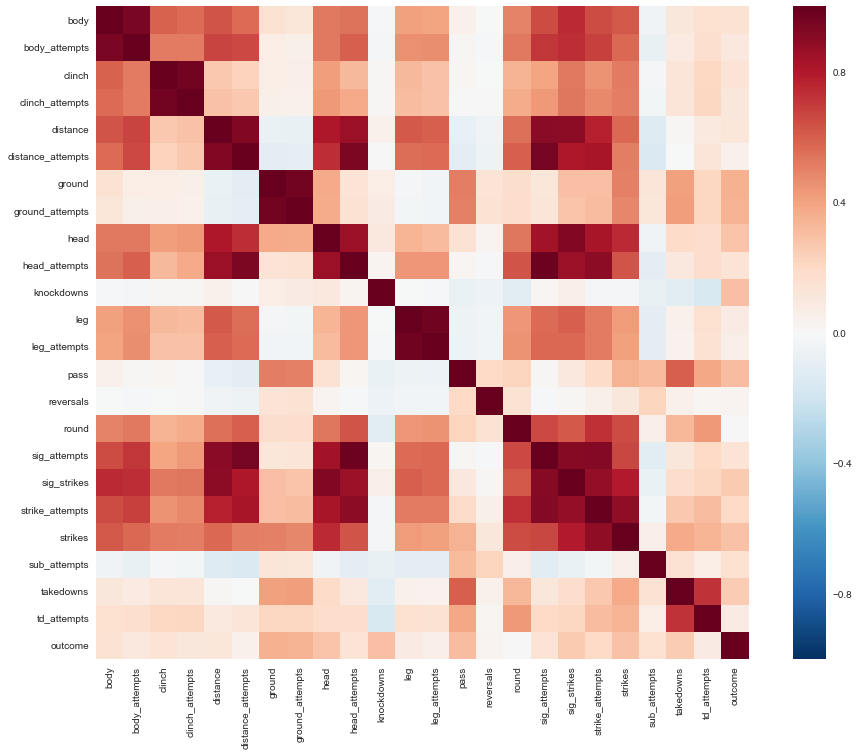

In [22]:
corrmat = fight_df.corr()
plt.figure(figsize=(16,12))
sns.heatmap(corrmat, square=True)
plt.show()

Wow, there appears to be a strong corrleation between every strike and strike attempt. Wayne Gretsky was right, "You miss 100% of the shots you don't take." There are several other related variables scattered throughout the dataset. It seems significant attempts, head attempts and distance attempts are all closely related. Also of note is the relationship between the number of passes and the number of takedowns. Interestingly, the number of knowckdowns does not seem to be strongly correlated with any particular variable. There is a small connection between knockdowns, win/loss and head strikes.

There does not appear to be a lot of negative correlations. The only small standouts are sub attempts to fight_id, knockdowns to takedown attempts and sub attempts to distance strikes. The last two make sense to a certain extent. If a a fighter is a good striker, they'd have little reason to try to take someone their opponent down and if they're they're a submission artist they would probably throw fewer distance strikes. The relationship between sub attempts and fight_id doesn't make as much sense to me right now. In the beginning, not many people were familiar with bjj so I would expect the number of submission attempts to grow over time. I'll have to take a closer look at that later.

Applying a log transform yields...

In [23]:
cols = [u'body', u'body_attempts', u'clinch', u'clinch_attempts', u'distance',
       u'distance_attempts', u'ground', u'ground_attempts',
       u'head', u'head_attempts', u'knockdowns', u'leg', u'leg_attempts',
       u'pass', u'reversals', u'sig_attempts', u'sig_strikes',
       u'strike_attempts', u'strikes', u'sub_attempts', u'takedowns',
       u'td_attempts']

fight_logs = fight_df.copy()
fight_logs.loc[:, cols] = fight_df[cols] + 1
fight_logs.loc[:, cols] = fight_logs[cols].apply(np.log)

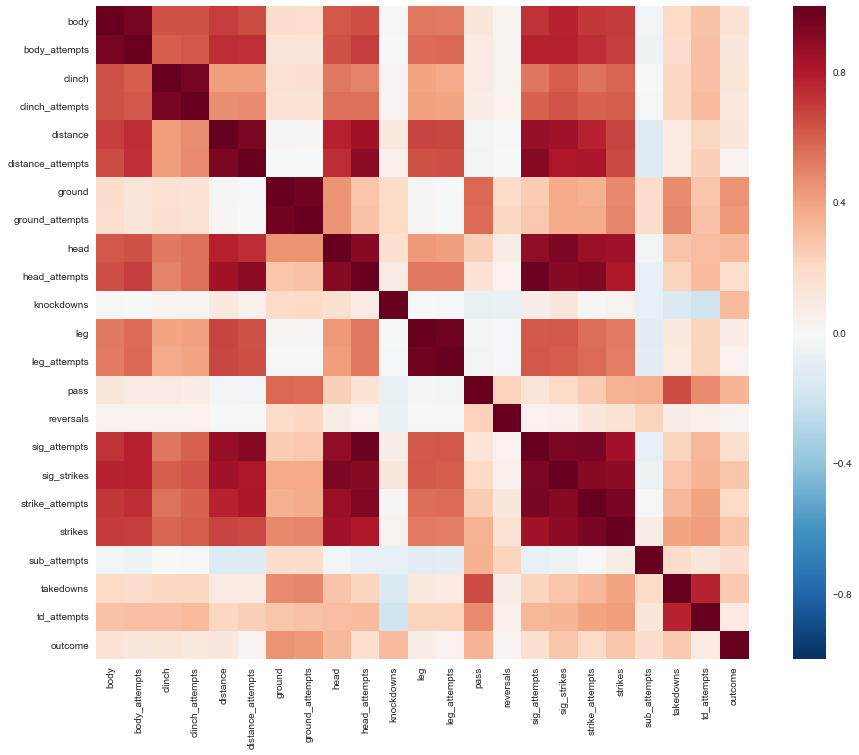

In [24]:
corrmat = fight_logs.drop(['fight_id', 'round'], axis=1).corr()
plt.figure(figsize=(16,12))
sns.heatmap(corrmat, square=True)
plt.show()

## Strike Targets

I was curious about how the number of strikes varied, depending on whether a fighter won or lost. On average, the winner outstruck the loser, but some margins were larger than others. For instance, the number of leg and body attacks were pretty evenly split, but the number of head strikes differed by about a 2:1 ratio. This may hold value for our classifiers later.

In [25]:
# Convert to long form first
strike_targets = [
        'body', 
        'body_attempts', 
        'head', 
        'head_attempts', 
        'leg',
        'leg_attempts'
    ]

targets_df = fight_df.melt(
    id_vars=['name', 'win/loss'], 
    value_vars=strike_targets)

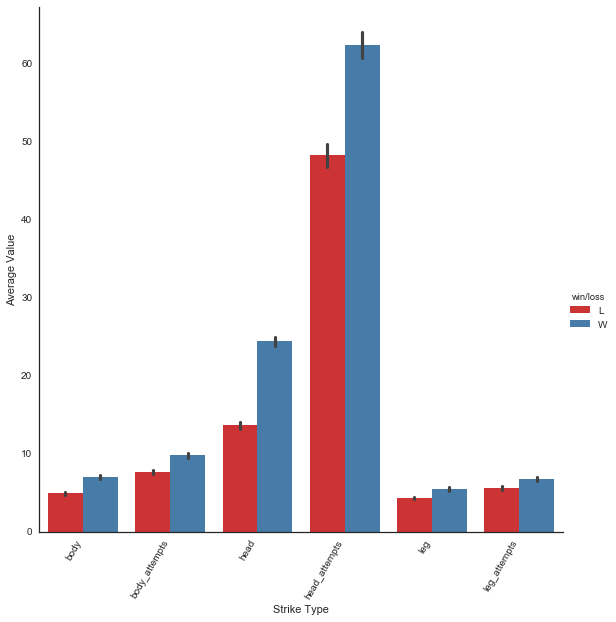

In [26]:
#plt.figure(figsize=(12,8))
sns.factorplot(
    x='variable', 
    y='value', 
    kind='bar', 
    hue='win/loss', 
    palette='Set1', 
    data=targets_df, 
    size=8
)
plt.ylabel('Average Value')
plt.xlabel('Strike Type')
plt.xticks(rotation=60, ha='right')
plt.show()

## Strike Types

For strike types, the differences between the population of fight winners and losers is even wider. For instance, the number of strikes landed is almost a 2:1 ratio between winners and losers, but the number of ground strikes landed is a 5:1 ratio. This tells me if a fighter can take the fight to the ground, they open up the opportunity to dominate the fight from there.

In [27]:
# Convert to long form first
strike_types = [
        'ground', 
        'ground_attempts', 
        'distance', 
        'distance_attempts', 
        'clinch',
        'clinch_attempts',
        'sig_strikes',
        'sig_attempts',
        'strikes',
        'strike_attempts',
    ]

types_df = fight_df.melt(
    id_vars=['name', 'win/loss'], 
    value_vars=strike_types)

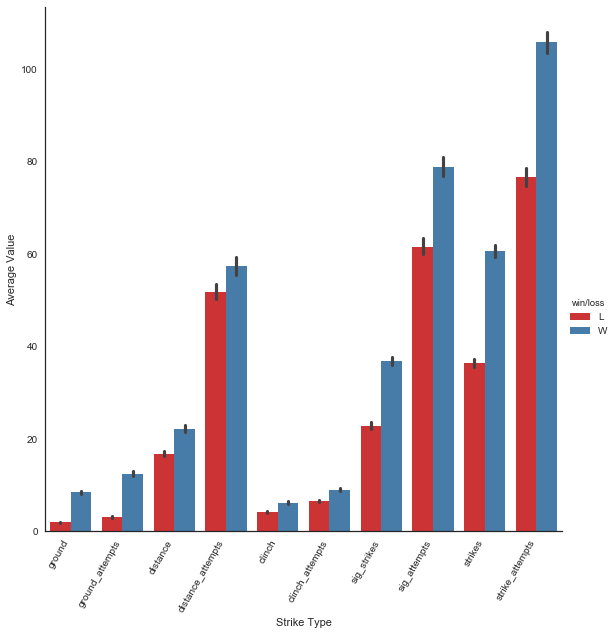

In [28]:
#plt.figure(figsize=(12,8))
sns.factorplot(
    x='variable', 
    y='value', 
    kind='bar', 
    hue='win/loss', 
    palette='Set1', 
    data=types_df, 
    size=8
)
plt.ylabel('Average Value')
plt.xlabel('Strike Type')
plt.xticks(rotation=60, ha='right')
plt.show()

## Grappling

Grappling statistics show a stark contrast between the winner and loser populations in every category except reversals. Winning fighters pass at a 3:1 ratio vs losing fighers, attempt twice as many submissions and take down their oppponents twice as frequently. One possible reason for the even split between reversals could be the nature of reversals itself. If a fighter completed a reversal, it means they were probably in trouble in the first place, so that may not have been enough to overcome whatever else happened in the fight.

In [29]:
grappling_vars = [
    'name',
    'win/loss',
    'sub_attempts',
    'pass',
    'reversals',
    'takedowns'
]


grappling_df = fight_df.melt(
    id_vars=['name', 'date', 'win/loss'], 
    value_vars=grappling_vars[2:])

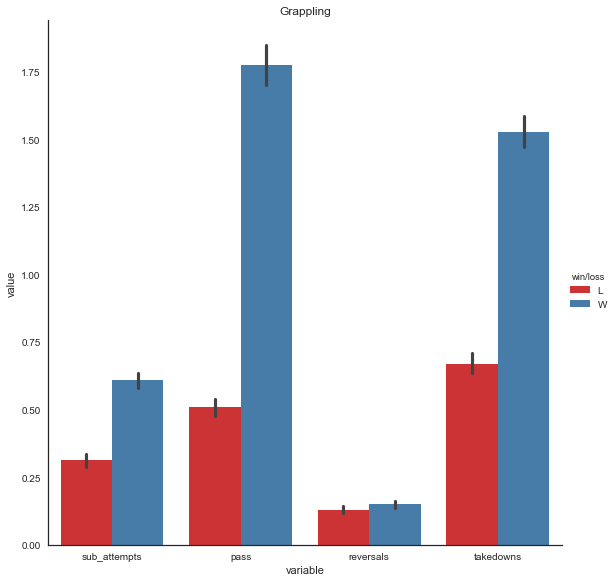

In [30]:
sns.factorplot(
    x='variable', 
    y='value', 
    kind='bar', 
    hue='win/loss', 
    palette='Set1', 
    data=grappling_df, 
    size=8
)
plt.title('Grappling')
plt.show()

Let's take at the distribution of submissions attempts vs the method used. My theory is that submission attempts are higher in fights that end that way.

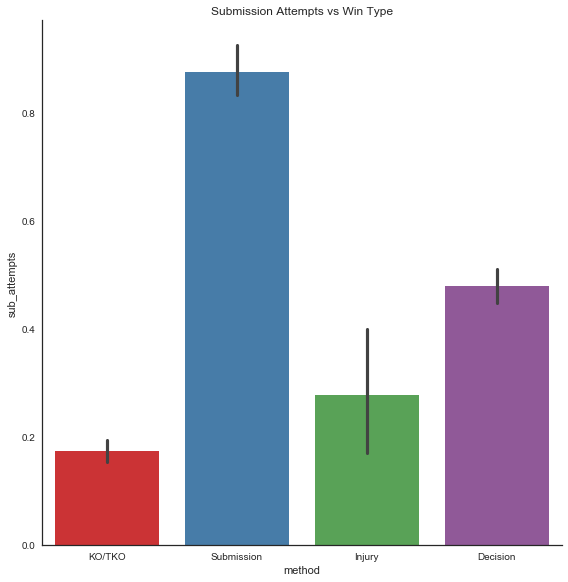

In [31]:
sns.factorplot(
    x='method', 
    y='sub_attempts', 
    kind='bar', 
    palette='Set1', 
    data=fight_df, 
    size=8
)
plt.title('Submission Attempts vs Win Type')
plt.show()

As expected, fights that end in submission have a higher percentage of submisssion attempts greater than zero. Interestingly, fights that end in decision are second highest in the average number of submission attempts. This could be due to the nature of how fights are scored overall since submission attempts do not give a fighter as many points as strikes.

## Knockdowns

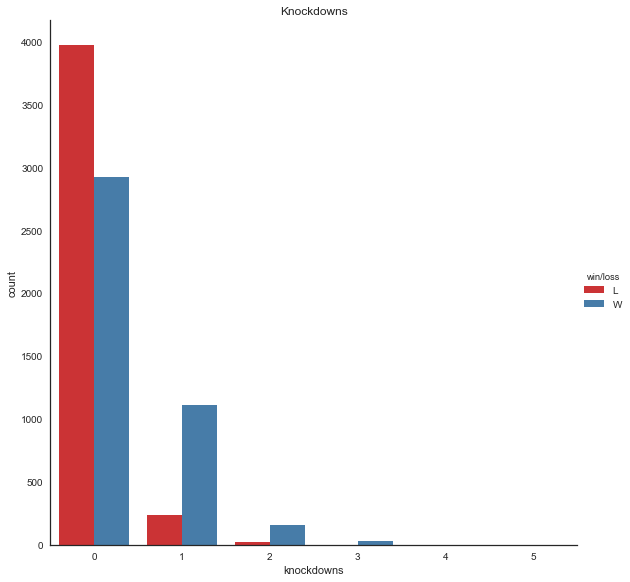

In [32]:
#plt.figure(figsize=(12,8))
sns.factorplot('knockdowns', hue='win/loss', palette='Set1', kind='count', data=fight_df, size=8)
plt.title('Knockdowns')
plt.show()

## Referees and Fighters

This was just a fun exercise to show how often different referees and fighters showed up in the database. The larger the name, the more prolific the person. 

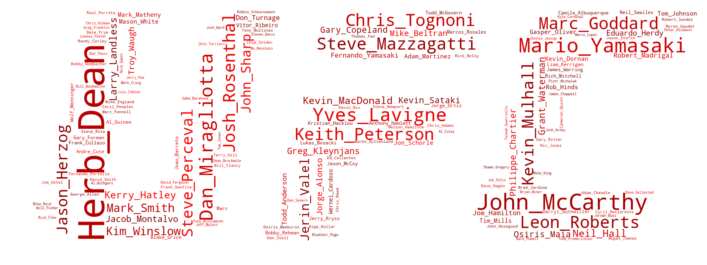

In [33]:
def custom_color_func(word, font_size, position, orientation, random_state=None,
                    **kwargs):
    return "hsl(0, 100%, {}%)".format(random.randint(25, 50))

# Extract referee text from fight_df
text = " ".join("_".join(ref.split()) for ref in fight_df[fight_df.referee.notnull()].referee.tolist())

# read the mask image
ufc_mask = np.array(Image.open("images/UFC_Logo.png"))

wc = WordCloud(background_color="white", mask=ufc_mask, random_state=42)
# generate word cloud
wc.generate(text)

wc.recolor(color_func=custom_color_func, random_state=3)

# store to file
wc.to_file("images/ufc_red_wordcloud.png")

# show
plt.figure(figsize=(12,8))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

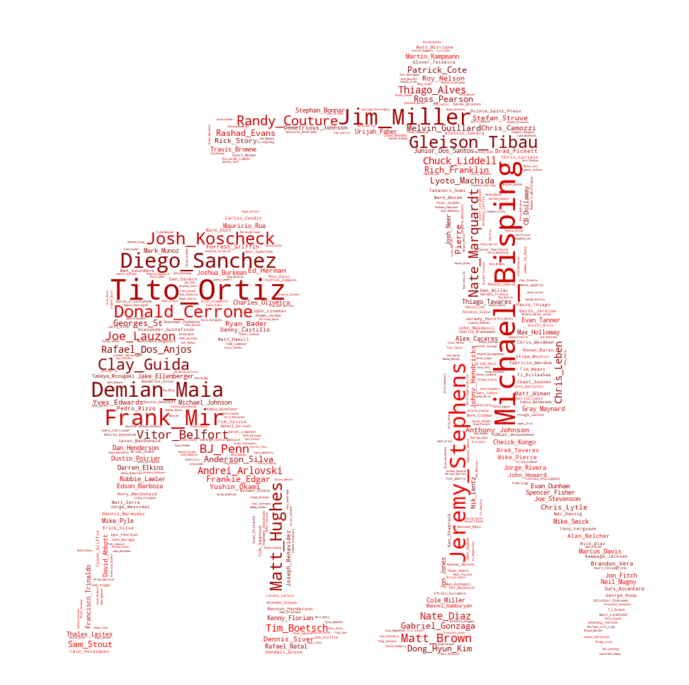

In [34]:
def custom_color_func(word, font_size, position, orientation, random_state=None,
                    **kwargs):
    return "hsl(0, 100%, {}%)".format(random.randint(25, 50))

# Extract referee text from fight_df
text = " ".join("_".join(fighter.split()) for fighter in fight_df[fight_df.name.notnull()].name.tolist())

# read the mask image
fighter_mask = np.array(Image.open("images/shadowboxing.jpg"))


wc = WordCloud(max_words=1000, background_color="white", mask=fighter_mask, random_state=1)
# generate word cloud
wc.generate(text)

wc.recolor(color_func=custom_color_func, random_state=3)

# store to file
wc.to_file("images/ufc_fighter_red_wordcloud.png")

# show
plt.figure(figsize=(14,12))
plt.imshow(wc.recolor(color_func=custom_color_func, random_state=3), interpolation='bilinear')
plt.axis("off")
plt.show()

# Multivariate Analysis

Now that we have an overview of the variables involved, let's take a look at some of the interactions.

## Strikes vs Win Percentage

We can see that as the number of strikes increases, the probability of winning increases as well up to a point. It appears that past 150 strikes, the win probability starts to taper off.

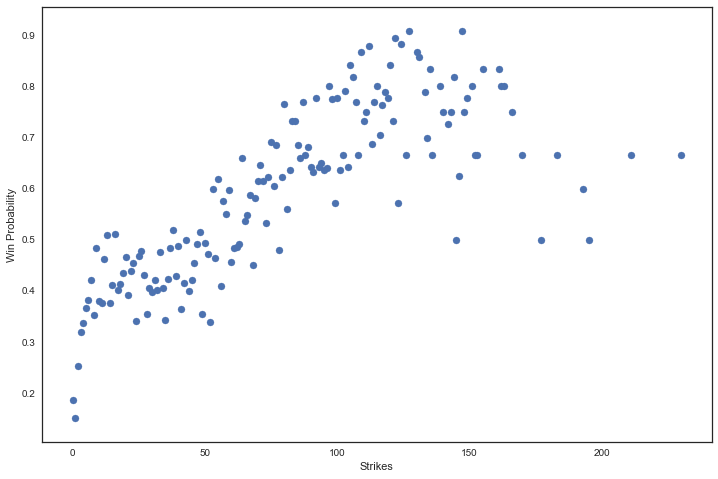

In [35]:
strike_wins = fight_df.loc[fight_df.outcome == 1, 'strikes'].value_counts()
strike_losses = fight_df.loc[fight_df.outcome == 0, 'strikes'].value_counts()
strike_overall = pd.concat([strike_wins, strike_losses], join="inner", axis=1)
strike_overall.columns = ['wins', 'losses']
strike_overall.win_perc = strike_overall.wins / (strike_overall.wins + strike_overall.losses)

plt.figure(figsize = (12,8))
plt.scatter(strike_overall.index, strike_overall.win_perc)
plt.xlabel('Strikes')
plt.ylabel('Win Probability')
plt.show()

## Trends Over Time

How have fights changed over time? Do fighters throw more or fewer strikes? Have there been more submission attempts? Curious minds want to know! Let's dig in.

### Strikes Landed Per Fight

So far I've been using matplotlib and seaborn for the visualizations, but I decided to switch it up this time and throw some ggplot into the mix. I really like the ggplot syntax in R because it is clean and in my opinion less clunky than matplotlib. In addition, ggplot has smoothing and loess functions that make it a snap to adjust the signal to noise ratio in time series data.

On average, we can see that the number of strikes thrown per fight has risen steadily over time. The black line tracks each individual event, which could include several fights in the same year, while the blue line applies a smoothing function to cut down the noise.

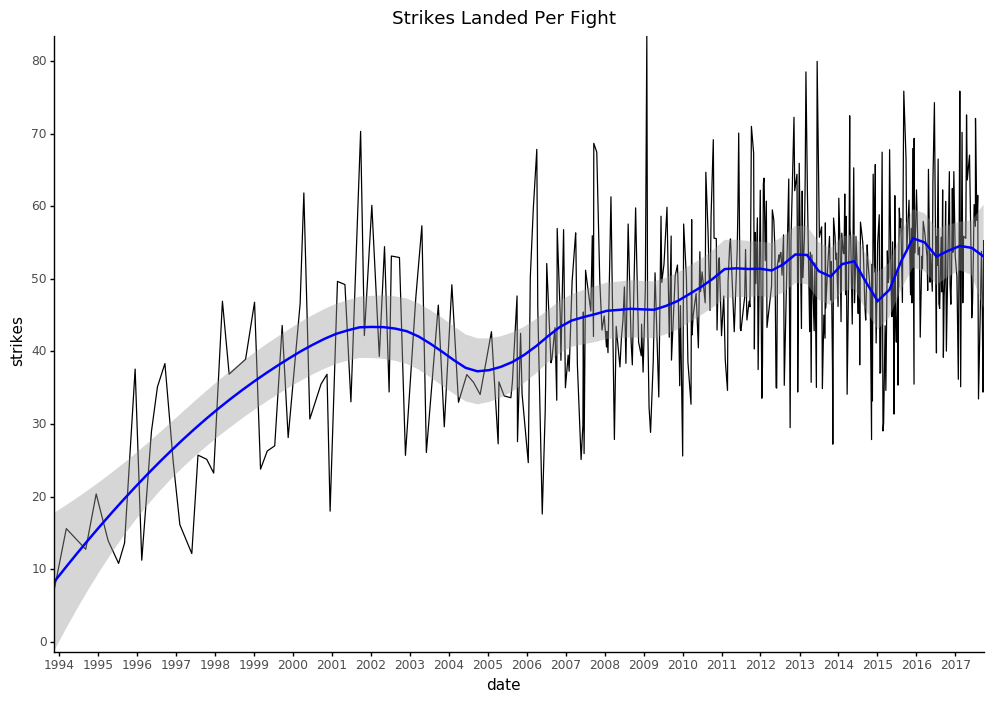

<ggplot: (292255293)>

In [36]:
(ggplot(aes(x='date', y='strikes'), data=fight_df.groupby('date')['strikes'].mean().reset_index())
 + geom_line()
 + stat_smooth(colour='blue', span=0.2)
 + scale_x_datetime(expand=[0,0], breaks=date_breaks('1 year'), labels=date_format('%Y'))
 + scale_y_continuous(expand=[0,0], breaks=range(0,90,10))
 + theme_classic()
 + theme(figure_size=(12, 8))
 + labs(title="Strikes Landed Per Fight")
)

### Clinch Use Per Fight

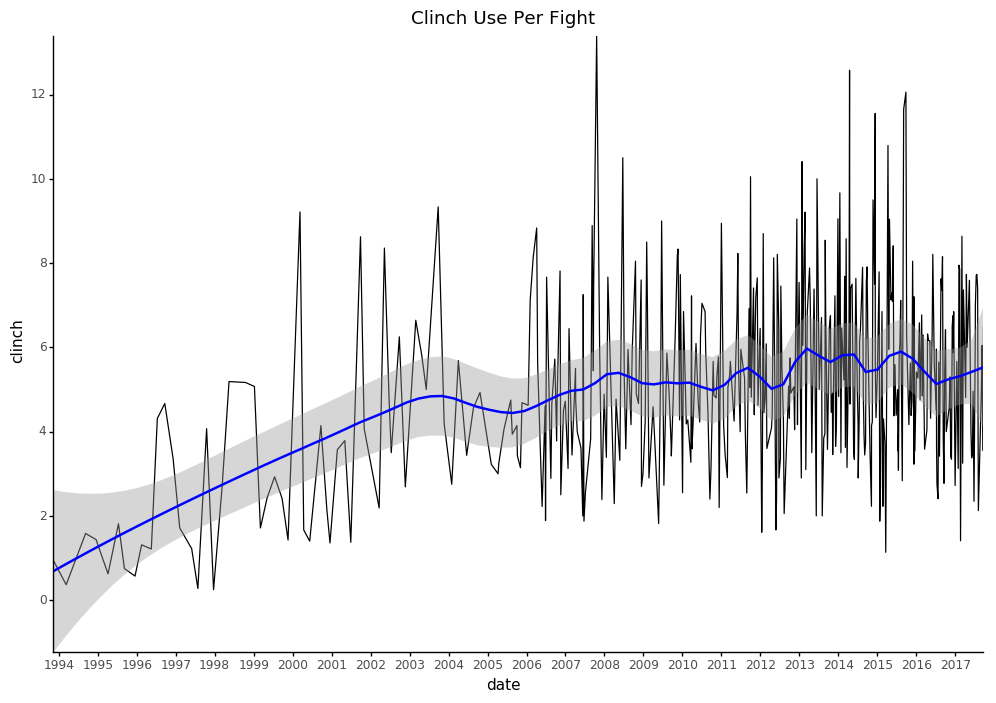

<ggplot: (287865961)>

In [37]:
(ggplot(aes(x='date', y='clinch'), data=fight_df.groupby('date')['clinch'].mean().reset_index())
 + geom_line()
 + stat_smooth(colour='blue', span=0.2)
 + scale_x_datetime(expand=[0,0], breaks=date_breaks('1 year'), labels=date_format('%Y'))
 + scale_y_continuous(expand=[0,0], breaks=range(0,16,2))
 + theme_classic()
 + theme(figure_size=(12, 8))
 + labs(title="Clinch Use Per Fight")
)

### Submissions Per Event

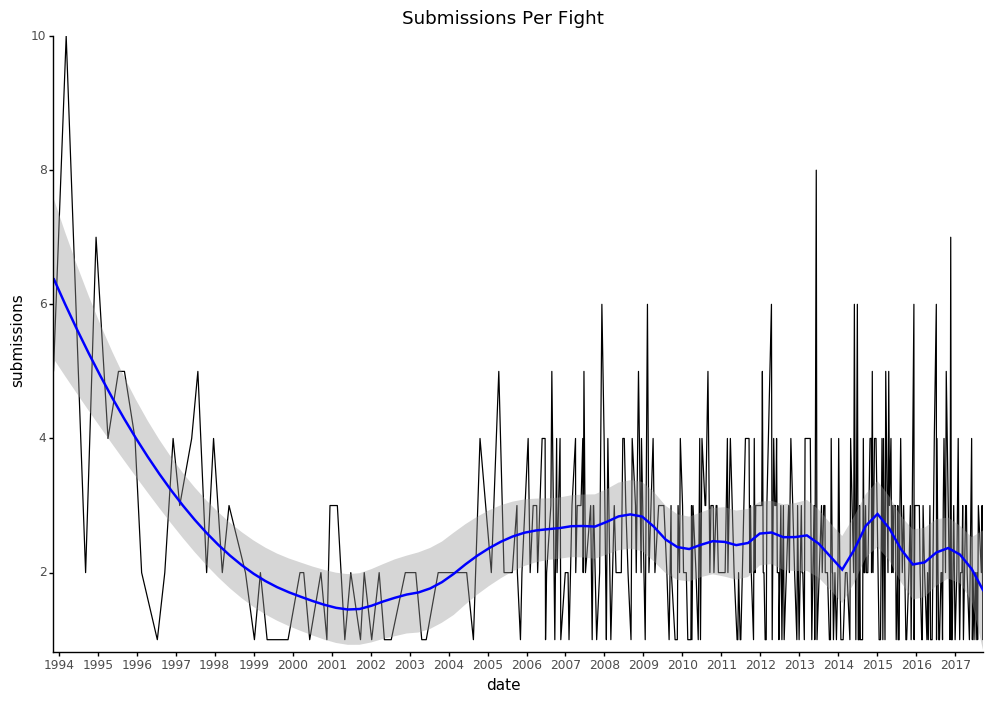

<ggplot: (287323853)>

In [38]:
sub_wins = fight_df[(fight_df['win/loss']=='W') & (fight_df['method']=='Submission')]
sub_wins = sub_wins.groupby(sub_wins.date)['name'].count().reset_index()
sub_wins = sub_wins.rename(columns={'name':'submissions'})
(ggplot(aes(x='date', y='submissions'), data=sub_wins)
 + geom_line()
 + stat_smooth(colour='blue', span=0.2)
 + scale_x_datetime(expand=[0,0], breaks=date_breaks('1 year'), labels=date_format('%Y'))
 + scale_y_continuous(expand=[0,0], breaks=range(0,16,2))
 + theme_classic()
 + theme(figure_size=(12, 8))
 + labs(title="Submissions Per Fight")
)

### Rounds Per Fight

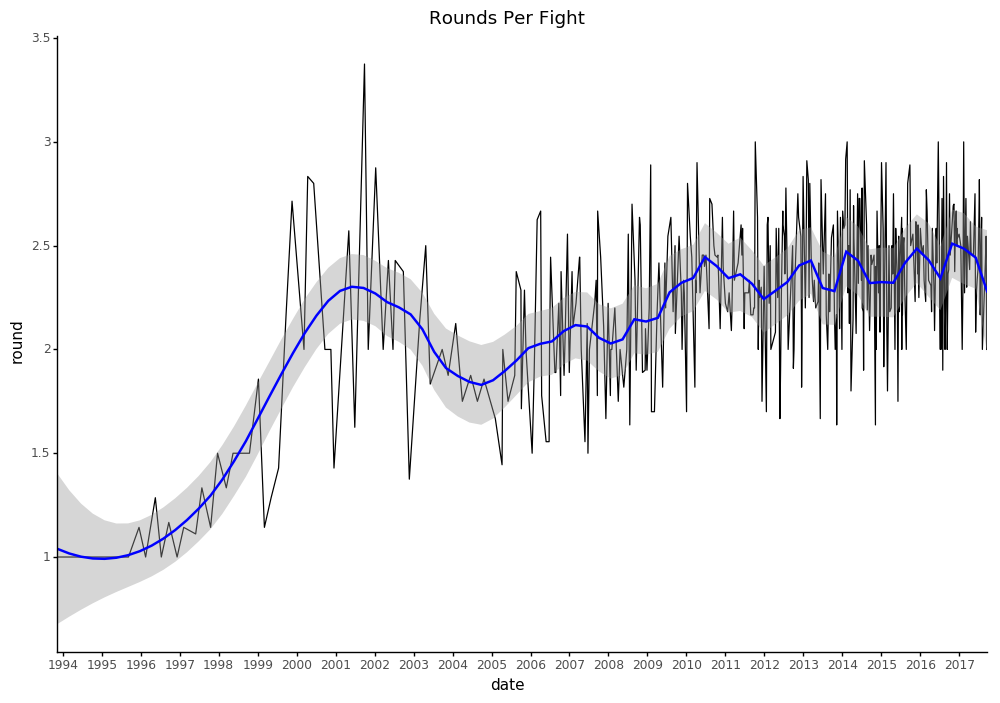

<ggplot: (291873125)>

In [39]:
(ggplot(aes(x='date', y='round'), data=fight_df.groupby(fight_df.date)['round'].mean().reset_index())
 + geom_line()
 + stat_smooth(colour='blue', span=0.1)
 + scale_x_datetime(expand=[0,0], breaks=date_breaks('1 year'), labels=date_format('%Y'))
 + theme_classic()
 + theme(figure_size=(12, 8))
 + labs(title="Rounds Per Fight")
)

### Submission Attempts Per Fight

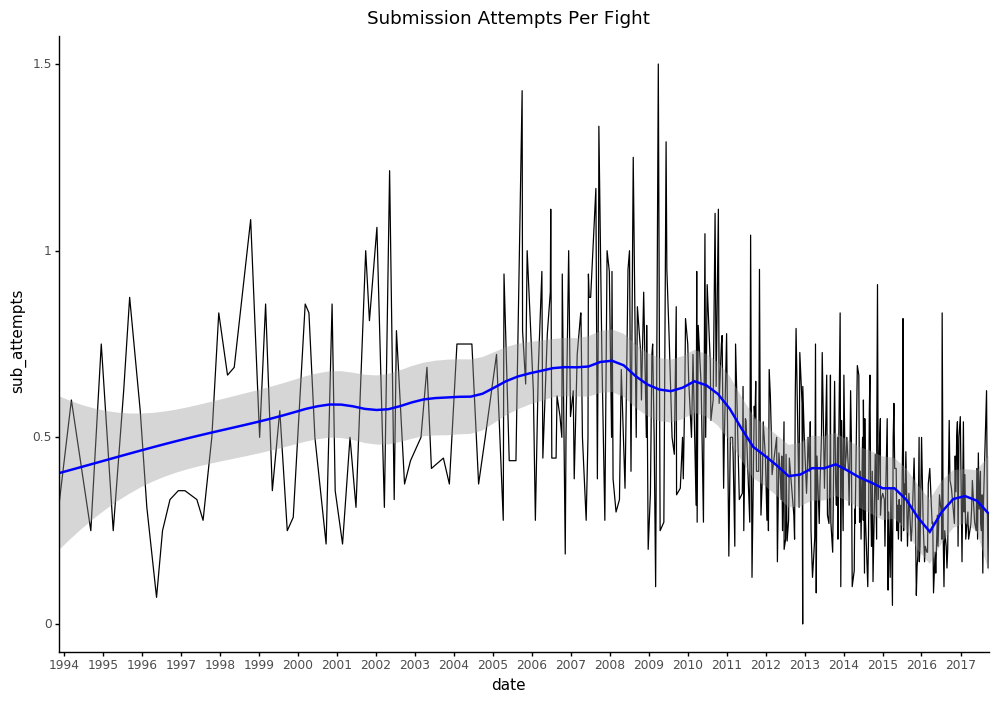

<ggplot: (285683125)>

In [40]:
sub_attempts = fight_df.groupby(fight_df.date)['sub_attempts'].mean().reset_index()
(ggplot(aes(x='date', y='sub_attempts'), data=sub_attempts)
 + geom_line()
 + stat_smooth(colour='blue', span=0.2)
 + scale_x_datetime(expand=[0,0], breaks=date_breaks('1 year'), labels=date_format('%Y'))
 + theme_classic()
 + theme(figure_size=(12, 8))
 + labs(title="Submission Attempts Per Fight")
)

### Fights Per Year

The number of fights per year grew exponentially until it peaked in 2014 and leveled off slightly. The sharp dip from 2016 to 2017 is slightly misleading since this data was scraped in September of 2017.

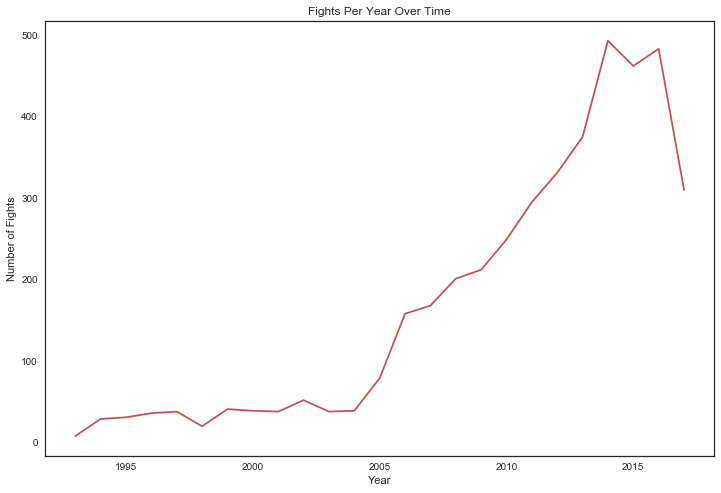

In [41]:
plt.figure(figsize=(12,8))
plt.plot(fight_df.groupby(fight_df.date.dt.year)['name'].count()/2, color=colors[2])
plt.title('Fights Per Year Over Time')
plt.xlabel('Year')
plt.ylabel('Number of Fights')
plt.show()

In [42]:
fight_df.date.dt.weekday_name.value_counts()/2

Saturday     3082.0
Friday        537.0
Sunday        248.0
Wednesday     234.0
Thursday       69.0
Tuesday        30.0
Monday         25.0
Name: date, dtype: float64

### Fight Finishes

This was one of the most interesting visualizations for me because it showed how different fighting strategies shifted over time. Submissions dominated in the beginning before being overtaken by knockouts from 1999-2008, which were then overtaken by judge's decision.

In [43]:
method_counts = fight_df[fight_df['win/loss']=='W'].groupby([fight_df.date.dt.year,'method'], as_index=True)['name'].count()
method_counts = method_counts.reset_index()
method_counts.rename(columns={'name':'count'}, inplace=True)

In [44]:
methods_complete = method_counts.pivot(index='date',columns='method',values='count')
methods_complete.fillna(0,inplace=True)
methods_complete.reset_index(drop=False,inplace=True)
methods_complete = methods_complete.melt(id_vars=['date'], var_name='method')
methods_complete = methods_complete.rename(columns={'value':'count'})
methods_complete[['date','count']] = methods_complete[['date','count']].astype(int)
methods_complete.index.name=None
methods_complete.sort_values(['date','method'],inplace=True)
methods_complete.reset_index(drop=True,inplace=True)

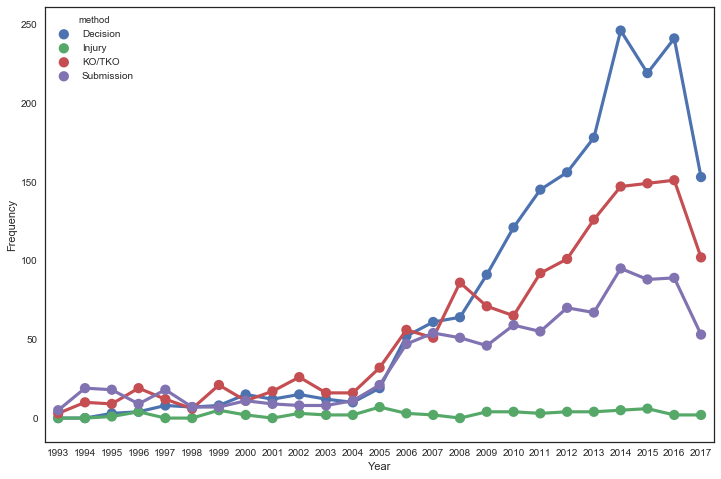

In [45]:
plt.figure(figsize=(12,8))
sns.pointplot(
    x='date', 
    y='count', 
    data=methods_complete, 
    hue='method',
    ci=None
)
plt.ylabel('Frequency')
plt.xlabel('Year')
plt.show()

## Fighter Rankings

How do fighters compare? Who's undefeated? Who is the most accurate striker? Who has the most KO's? In the next section, we'll group fight data by fighter and take a closer look.


### Win Percentage

There were a surprising number of undefeated fighters in the dataset, so I narrowed the view to fighters with at least 5 fights who have fought within the last 2 years. Even with this restriction, there were 8 undefeated fighters.

In [46]:
# Restrict to fighters with at least 5 fights who have fought within the last 2 years
repeat_fighters = fight_df[(fight_df.groupby('name').distance.transform(len)>=5) & (fight_df.groupby('name')['date'].transform(max)>=datetime(2015, 1, 1))]
repeat_fighters = repeat_fighters.groupby('name')
win_percentages = repeat_fighters.agg({'outcome':'sum'})/repeat_fighters.agg({'outcome':'count'})
win_percentages = win_percentages.reset_index().sort_values(by=['outcome'])[::-1]
win_percentages.outcome *= 100

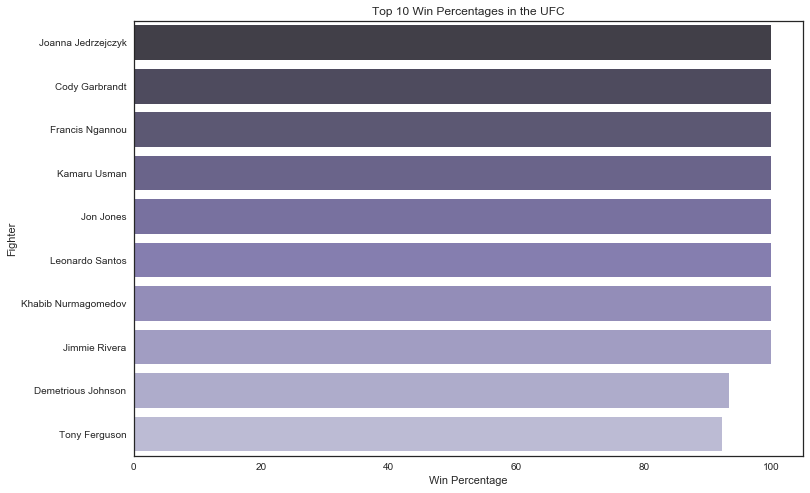

In [47]:
plt.figure(figsize=(12,8))
sns.barplot(y='name', x='outcome', data= win_percentages[:10], palette="Purples_d")
plt.title('Top 10 Win Percentages in the UFC')
plt.xlabel('Win Percentage')
plt.ylabel('Fighter')
plt.show()

### Strike Accuracy

In [48]:
recent_fighters = fight_df[(fight_df.groupby('name')['date'].transform(len)>=5)&(fight_df.groupby('name')['date'].transform(max)>=datetime(2015,1,1))]
strike_accuracy = recent_fighters.groupby('name')['strikes'].sum()/recent_fighters.groupby('name')['strike_attempts'].sum()
strike_accuracy = strike_accuracy.reset_index().dropna().sort_values(by=[0])[::-1]
strike_accuracy[0] *= 100

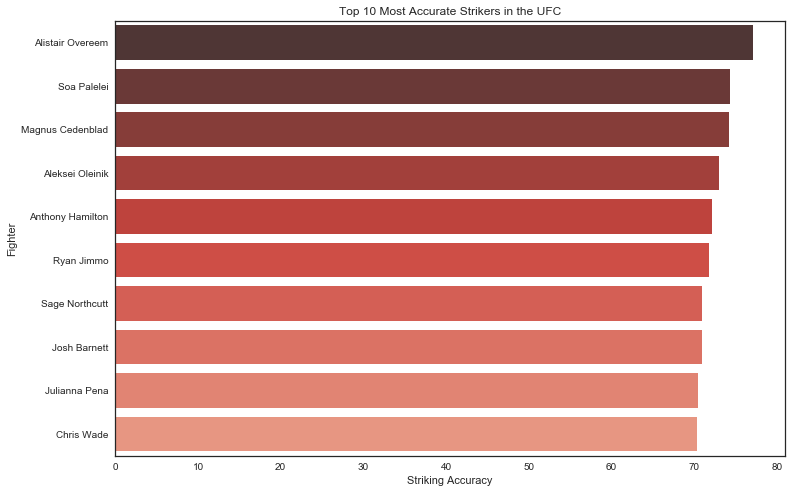

In [49]:
plt.figure(figsize=(12,8))
sns.barplot(y='name', x=0, data= strike_accuracy[:10], palette="Reds_d")
plt.title('Top 10 Most Accurate Strikers in the UFC')
plt.xlabel('Striking Accuracy')
plt.ylabel('Fighter')
plt.show()

### Significant Strike Accuracy

In [50]:
# Restrict to fighters with at least 5 fights and who have fought since 2012
recent_fighters = fight_df[(fight_df.groupby('name')['date'].transform(len)>=5)&(fight_df.groupby('name')['date'].transform(max)>=datetime(2012,1,1))]
sig_strike_accuracy = recent_fighters.groupby('name')['sig_strikes'].sum()/recent_fighters.groupby('name')['sig_attempts'].sum()
sig_strike_accuracy = sig_strike_accuracy.reset_index().dropna().sort_values(by=[0])[::-1]
sig_strike_accuracy[0] *= 100

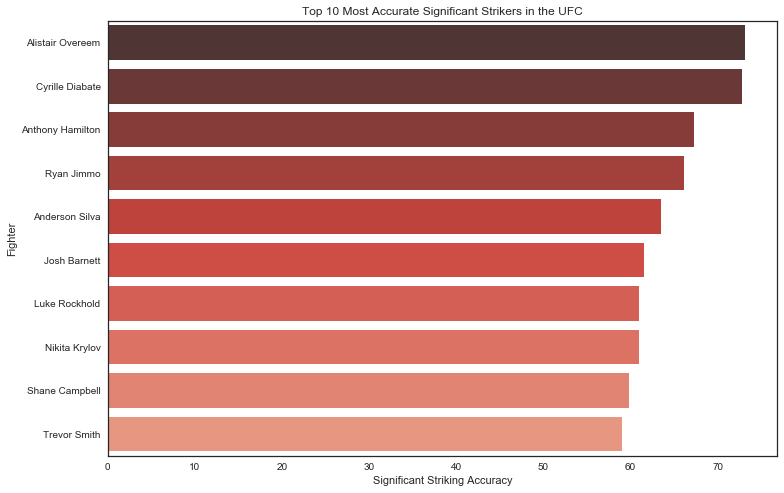

In [51]:
plt.figure(figsize=(12,8))
sns.barplot(y='name', x=0, data= sig_strike_accuracy[:10], palette="Reds_d")
plt.title('Top 10 Most Accurate Significant Strikers in the UFC')
plt.xlabel('Significant Striking Accuracy')
plt.ylabel('Fighter')
plt.show()

### Most Takedowns

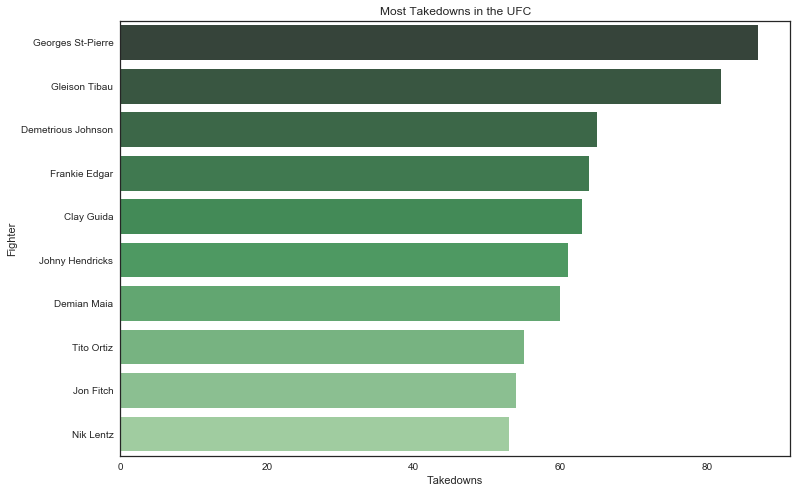

In [52]:
takedowns = fight_df.groupby('name').sum().takedowns.reset_index().sort_values(by=['takedowns'])[::-1]
plt.figure(figsize=(12,8))
sns.barplot(y='name', x='takedowns', data= takedowns[:10], palette="Greens_d")
plt.title('Most Takedowns in the UFC')
plt.xlabel('Takedowns')
plt.ylabel('Fighter')
plt.show()

### Most Accurate Takedowns

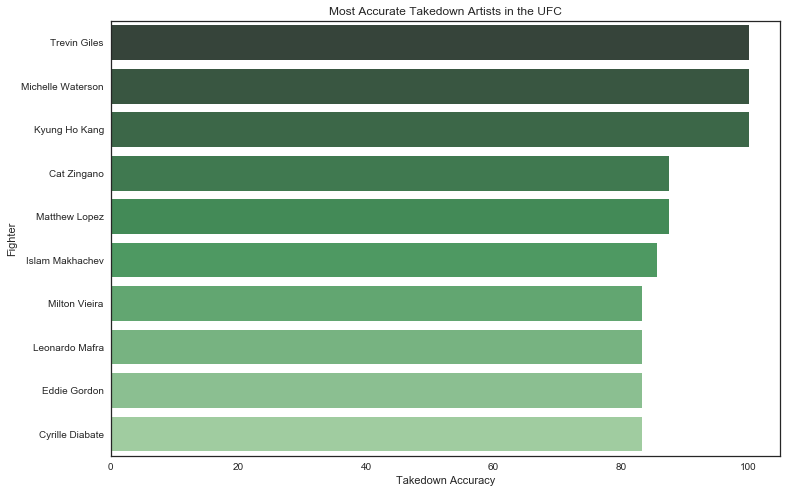

In [53]:
# Restrict to fighters with at least 5 takedowns who have fought within the last 5 years
recent_fighters = fight_df[(fight_df.groupby('name').takedowns.transform(sum)>=5)&(fight_df.groupby('name')['date'].transform(max)>datetime(2012,1,1))]
takedown_accuracy = recent_fighters.groupby('name').sum().takedowns/recent_fighters.groupby('name').sum().td_attempts
takedown_accuracy = takedown_accuracy.reset_index().dropna().sort_values(by=[0])[::-1]
takedown_accuracy[0] *= 100
plt.figure(figsize=(12,8))
sns.barplot(y='name', x=0, data= takedown_accuracy[:10], palette="Greens_d")
plt.title('Most Accurate Takedown Artists in the UFC')
plt.xlabel('Takedown Accuracy')
plt.ylabel('Fighter')
plt.show()

### Most KOs, Submissions and Decisions

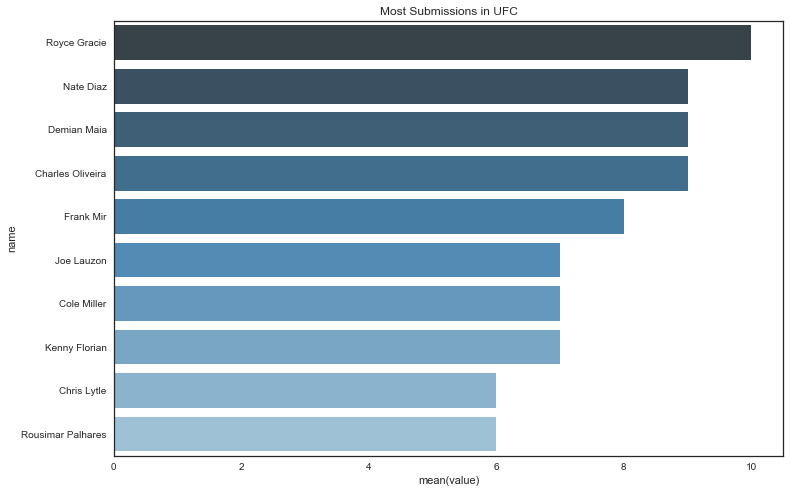

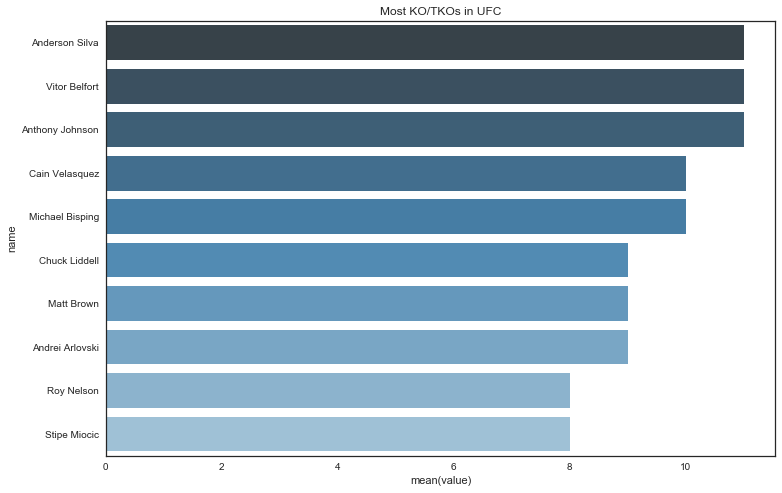

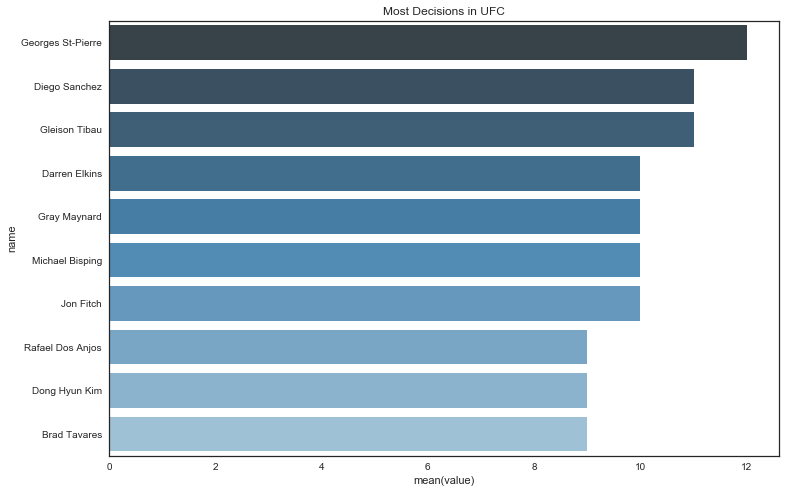

In [54]:
win_type = fight_df[fight_df['win/loss']=='W'].groupby(['name','method']).outcome.count()
win_type = win_type.reset_index()
win_type = win_type.rename(columns={'outcome':'value'})
win_type = win_type.sort_values(by=['value'])[::-1]
for method in ['Submission', 'KO/TKO', 'Decision']:
    plt.figure(figsize=(12,8))
    sns.barplot(y='name', x='value', data=win_type[win_type.method==method][:10], palette='Blues_d')
    plt.title('Most {}s in UFC'.format(method))
plt.show()

### Longest Win Streak

In [55]:
temp_df = fight_df.groupby('name')
streaks = []
for name in fight_df.name.unique():
    s = 0
    max_s = 0
    fighter = temp_df.get_group(name)
    #display(george.values)
    for fight in fighter.itertuples():
        if fight.outcome:
            s += 1
            max_s = max(max_s,s)
        else:
            s = 0
    streaks.append([name,max_s])
    
streaks_sorted = sorted(streaks, key=lambda x: x[1], reverse = True)

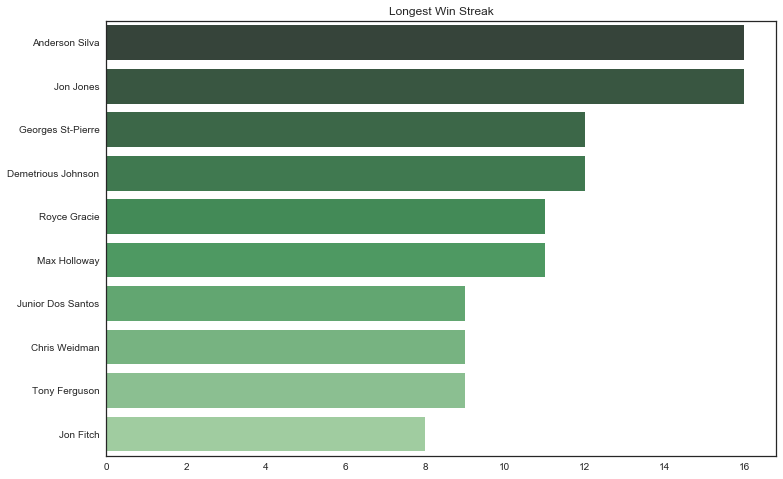

In [56]:
names = [streak[0] for streak in streaks_sorted[:10]]
streak_len = [streak[1] for streak in streaks_sorted[:10]]
plt.figure(figsize=(12,8))
sns.barplot(
    y=names,
    x=streak_len,
    palette='Greens_d'
)
plt.title('Longest Win Streak')
plt.show()

# Data Cleaning

The first step in data cleaning is to remove obvious outliers and columns that will not contribute to the model. We've already dropped no contests, DQ's and draws. Let's check other areas.

## Logical Errors

Now that the missing values have been taken care of, it might be a good idea to check for any logical errors. Any situations where strikes landed > strikes attempted, takedowns > takedown attempts, etc should be looked at carefully. Let's run a short script to see if any of the above situations are present.

In [57]:
a_cols = [
    u'body_attempts', u'clinch_attempts', u'distance_attempts',
    u'ground_attempts', u'head_attempts', u'leg_attempts', u'sig_attempts',
    u'strike_attempts', u'td_attempts'
]

l_cols = [
    u'body', u'clinch', u'distance', u'ground', u'head', u'leg', u'sig_strikes',
    u'strikes', u'takedowns'
]

for attempts, landed in zip(a_cols, l_cols):
    if len(fight_df[fight_df[attempts]<fight_df[landed]][[attempts,landed]])>0:
        print attempts
        print fight_df[fight_df[attempts]<fight_df[landed]][[attempts,landed]]

Looks good, there are no records where the number of techniques attempted exceeds the number of techniques landed.

# Feature Engineering

What is it about each figher that makes him a favorite? Is it the difference in strikes, in takedown percentage? The judging [rules](http://www.ufc.com/discover/sport/rules-and-regulations#14) state that fighters will be scored according to effective striking, grappling aggression and octogon control. We will use this to our advantage to identify patterns in fight outcomes.

## Creating Accuracy Columns

We will add a column for accuracy and see how it affects the model.

In [58]:
a_cols = [
    u'body_attempts', u'clinch_attempts', u'distance_attempts',
    u'ground_attempts', u'head_attempts', u'leg_attempts', u'sig_attempts',
    u'strike_attempts', u'td_attempts'
]

l_cols = [
    u'body', u'clinch', u'distance', u'ground', u'head', u'leg', u'sig_strikes',
    u'strikes', u'takedowns'
]

for attempt, landed in zip(a_cols, l_cols):
    accuracy_col = landed+'_accuracy'
    fight_df[accuracy_col] = fight_df.takedowns/fight_df.td_attempts
    fight_df[accuracy_col] = fight_df[accuracy_col].fillna(0)

## Comparing Winners and Losers

Next, we will create a running tally of differences between each fighter in each fight. My hope is that by comparing the winners and losers of each individual fight, we might be able to determine which features, if any can predict success in the UFC.

The following script sorts the dataframe by id and then by win/loss so that the fight loser is always presented first.

In [59]:
fight_df.sort_values(['fight_id', 'win/loss'], inplace=True)
fight_df.index = range(len(fight_df))
len(fight_df[(fight_df['win/loss']=='W') & (fight_df.index%2==0)])

0

The losing fighters are now presented first, which will make the process of separating winners and losers slightly easier.

### Fighter Differences and Accuracies

This block adds accuracy features for each fighter. It creates a ratio of strikes attempted vs strikes landed for each applicable category.

In [60]:
cols = [u'body', u'body_attempts', u'clinch', u'clinch_attempts', u'distance',
       u'distance_attempts', u'ground', u'ground_attempts',
       u'head', u'head_attempts', u'knockdowns', u'leg', u'leg_attempts',
       u'pass', u'reversals', u'sig_attempts', u'sig_strikes',
       u'strike_attempts', u'strikes', u'sub_attempts', u'takedowns',
       u'td_attempts']

acc_cols = [
    u'body_accuracy', u'clinch_accuracy', u'distance_accuracy',
       u'ground_accuracy', u'head_accuracy', u'leg_accuracy',
       u'sig_strikes_accuracy', u'strikes_accuracy', u'takedowns_accuracy'
]

cols += acc_cols

scaler = MinMaxScaler()
scaler.fit(fight_df[cols])
fight_df[cols] = scaler.transform(fight_df[cols])

fighter_a = fight_df[fight_df.index%2==0]
fighter_b = fight_df[fight_df.index%2==1]

fighter_a.reset_index(inplace=True, drop=True)
fighter_b.reset_index(inplace=True, drop=True)

fight_loser_diff = fighter_a.copy()
fight_winner_diff = fighter_b.copy()

fight_loser_ratio = fighter_a.copy()
fight_winner_ratio = fighter_b.copy()

fight_loser_diff.loc[:, cols] = fighter_a[cols] - fighter_b[cols]
fight_winner_diff.loc[:, cols] = fighter_b[cols] - fighter_a[cols]

In [61]:
fight_diffs = pd.concat(
    [fight_winner_diff,fight_loser_diff],
    ignore_index=True
    )

The following plots show that fight winners and losers show clear separation across the number of ground strikes, overall strikes and clinches landed.

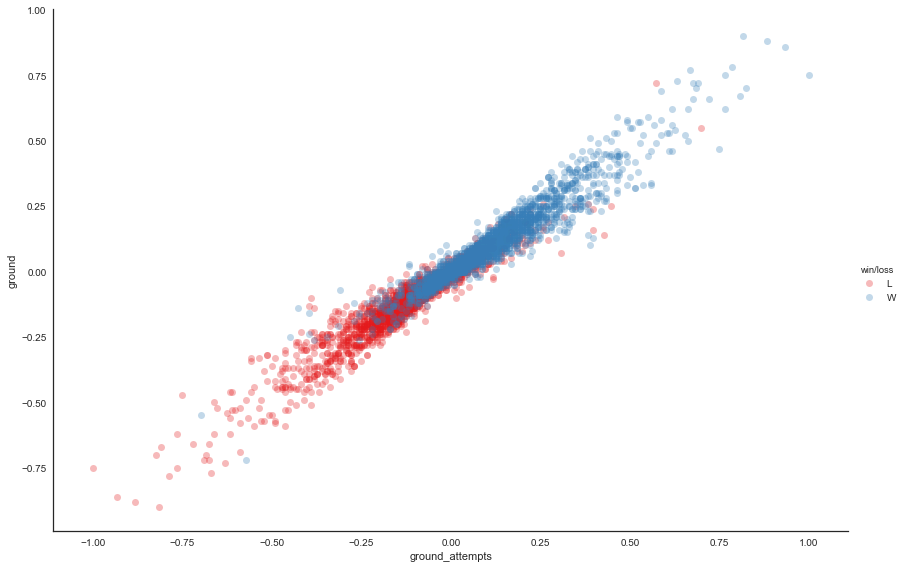

In [62]:
sns.lmplot(
    'ground_attempts',
    'ground',
    data=fight_diffs[::-1],
    hue='win/loss',
    palette='Set1',
    scatter_kws={'alpha':.3},
    fit_reg=False,
    size=8,
    aspect=1.5
)
plt.show()

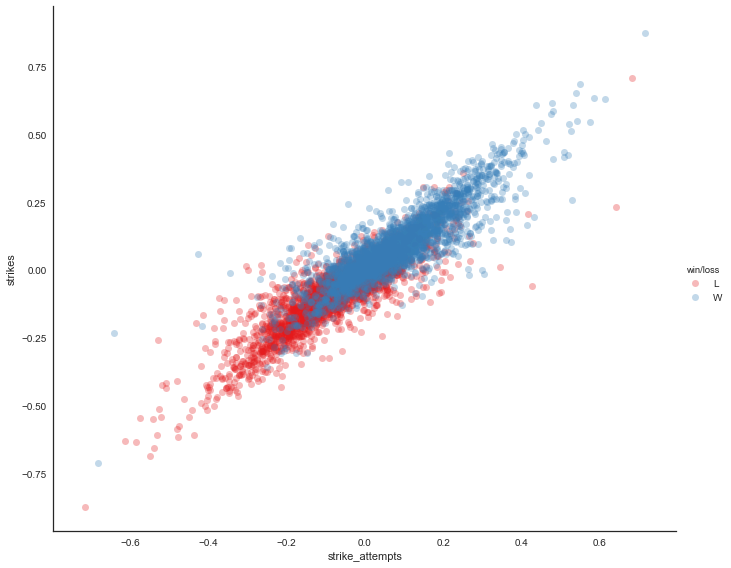

In [63]:
sns.lmplot(
    'strike_attempts',
    'strikes',
    data=fight_diffs[::-1],
    hue='win/loss',
    palette='Set1',
    scatter_kws={'alpha':.3},
    fit_reg=False,
    size=8,
    aspect=1.2
)
plt.show()

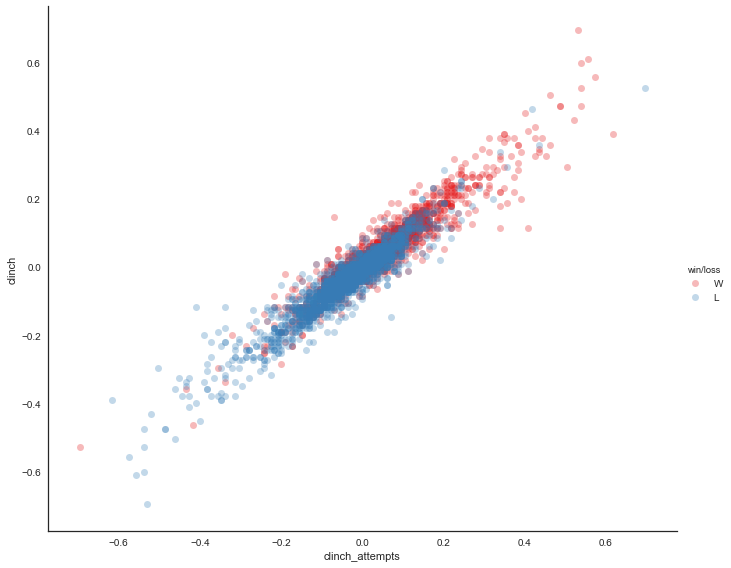

In [64]:
sns.lmplot(
    'clinch_attempts',
    'clinch',
    data=fight_diffs,
    hue='win/loss',
    palette='Set1',
    scatter_kws={'alpha':.3},
    fit_reg=False,
    size=8,
    aspect=1.2
)
plt.show()

### Running Tallies

The next step is to get a running tally of each fighter's stats and compare them to his or her opponent. The first step will be to get the sum of all stats up to current divided by the number of fights.

In [65]:
fight_copy = fight_df.copy()
for i in fight_df.index:
    cur_name = fight_df.loc[i, 'name']
    prev_fights = fight_df.iloc[:i]
    fight_copy.loc[i, cols] = np.mean(prev_fights.loc[prev_fights.name == cur_name, cols])

In [66]:
fight_copy = fight_copy.iloc[1:]
test_copy = fight_copy.copy()

Now that we have a running tally, the next step is to exclude all fights where one of the fighters is making their debut.

In [67]:
for i in test_copy.fight_id.tolist():
    f1 = test_copy[(test_copy.fight_id == i) & (test_copy.outcome == 1)]
    f2 = test_copy[(test_copy.fight_id == i) & (test_copy.outcome == 0)]
    if sum(f1.isnull().any().values) or sum(f2.isnull().any().values):
        test_copy = test_copy[test_copy.fight_id != i]

test_copy
fight_tallies = test_copy.copy()

The next step is to subtract the differences between each fighter, then take the log difference. Fortunately, we have the code for that!

#### Differences

In [68]:
fight_tallies.reset_index(inplace=True, drop=True)

In [69]:
fighter_x = fight_tallies[fight_tallies.index%2==0]
fighter_y = fight_tallies[fight_tallies.index%2==1]

fighter_x.reset_index(inplace=True, drop=True)
fighter_y.reset_index(inplace=True, drop=True)

tally_loser_diff = fighter_x.copy()
tally_winner_diff = fighter_y.copy()

tally_loser_diff.loc[:, cols] = fighter_x[cols] - fighter_y[cols]
tally_winner_diff.loc[:, cols] = fighter_y[cols] - fighter_x[cols]

In [70]:
tally_diffs = pd.concat(
    [tally_loser_diff, tally_winner_diff],
    ignore_index=True
    )

# Modeling

We're going to be methodical when building and testing our algorithms. It's easy to run in circles due to the plethora of algorithms and parameters available. Is a decision tree a better choice? Or should we try Random Forest? What about Support Vector Machines? The machines need our support! Rather than going through all these possibilities and forgetting the results, we'll build pipelines and document our process as we go along. By staying organized, it will be easier to tell if we've already tried a solution. It may also serve to highlight the desired path a bit (one can only hope).

Here's a list of models we have so far. We may add to this list, but it's a good starting place.

1. Perceptron
2. Random Forests
3. Decision Trees Classifier
4. SGD Classifier
5. Support Vector Machines
5. Linear Support Vector Machines
6. Gaussian NB
7. KNN

Of course, machine learning isn't just about finding that perfect algorithm. The results depend heavily on earlier steps in the process. One might even say that most of the accuracy depends on the exploratory analysis and feature engineering. That's why so much time was spent in that phase.

Now that we have a few algorithms to explore, we'll pay close attention to each one's hyperparameters. If the data is unbalanced, we'll need to account for that and if it's overfitting / underfitting, we may have to make a different set of changes. There's a lot to absorb here. Let's take our time and keep in mind that data analysis is not a linear process. Sometimes we have to go back and forth between modeling, wrangling, exploring and feature engineering. We can't be afraid to get our hands dirty!

## Extracting Features and Labels

### Numerical Differences

In [71]:
numerical_diffs = fight_diffs.select_dtypes(include=[np.int64, 'float'])
numerical_diffs = numerical_diffs.drop(['round'], axis=1)

### Tally Differences

In [72]:
numerical_tally_diffs = tally_diffs.select_dtypes(include=[np.int64, np.float])
numerical_tally_diffs = numerical_tally_diffs.drop(['round'], axis=1)

## Models

In [73]:
# We store the prediction of each model in our dict
# Also included helper functions for each model

def percep(X_train,Y_train,X_test,Y_test,Models):
    perceptron = Perceptron(max_iter = 1000, tol = 0.001, random_state=42)
    perceptron.fit(X_train, Y_train)
    Y_pred = perceptron.predict(X_test)
    Models['Perceptron'] = [
        accuracy_score(Y_test,Y_pred),
        precision_score(Y_test, Y_pred),
        recall_score(Y_test, Y_pred),
        confusion_matrix(Y_test,Y_pred),
    ]
    return

def ranfor(X_train,Y_train,X_test,Y_test,Models):
    randomfor = RandomForestClassifier(max_features="sqrt",
                                       n_estimators = 700,
                                       max_depth = None,
                                       n_jobs=-1,
                                       random_state=42
                                      )
    randomfor.fit(X_train,Y_train)
    Y_pred = randomfor.predict(X_test)
    Models['Random Forests'] = [
        accuracy_score(Y_test,Y_pred),
        precision_score(Y_test, Y_pred),
        recall_score(Y_test, Y_pred),
        confusion_matrix(Y_test,Y_pred),
    ]
    return

def dec_tree(X_train,Y_train,X_test,Y_test,Models):
    decision_tree = DecisionTreeClassifier(random_state=42)
    decision_tree.fit(X_train, Y_train)
    Y_pred = decision_tree.predict(X_test)
    Models['Decision Tree'] = [
        accuracy_score(Y_test,Y_pred),
        precision_score(Y_test, Y_pred),
        recall_score(Y_test, Y_pred),
        confusion_matrix(Y_test,Y_pred),
    ]
    return

def SGDClass(X_train,Y_train,X_test,Y_test,Models):
    sgd = SGDClassifier(max_iter = 1000, tol = 0.001, penalty='l1', random_state=42)
    sgd.fit(X_train, Y_train)
    Y_pred = sgd.predict(X_test)
    Models['SGD Classifier'] = [
        accuracy_score(Y_test,Y_pred),
        precision_score(Y_test, Y_pred),
        recall_score(Y_test, Y_pred),
        confusion_matrix(Y_test,Y_pred),
    ]
    return

def SVCClass(X_train,Y_train,X_test,Y_test,Models):
    svc = SVC(random_state=42)
    svc.fit(X_train, Y_train)
    Y_pred = svc.predict(X_test)
    Models['SVM'] = [
        accuracy_score(Y_test,Y_pred),
        precision_score(Y_test, Y_pred),
        recall_score(Y_test, Y_pred),
        confusion_matrix(Y_test,Y_pred),
    ]
    return

def linSVC(X_train,Y_train,X_test,Y_test,Models):
    linear_svc = LinearSVC(random_state=42)
    linear_svc.fit(X_train, Y_train)
    Y_pred = linear_svc.predict(X_test)
    Models['Linear SVM'] = [
        accuracy_score(Y_test,Y_pred),
        precision_score(Y_test, Y_pred),
        recall_score(Y_test, Y_pred),
        confusion_matrix(Y_test,Y_pred),
    ]
    return

def bayes(X_train,Y_train,X_test,Y_test,Models):
    gaussian = GaussianNB()
    gaussian.fit(X_train, Y_train)
    Y_pred = gaussian.predict(X_test)
    Models['Bayes'] = [
        accuracy_score(Y_test,Y_pred),
        precision_score(Y_test, Y_pred),
        recall_score(Y_test, Y_pred),
        confusion_matrix(Y_test,Y_pred),
    ]
    return

def Nearest(X_train,Y_train,X_test,Y_test,Models):
    knn = KNeighborsClassifier(n_neighbors = 3)
    knn.fit(X_train, Y_train)
    Y_pred = knn.predict(X_test)
    Models['KNN'] = [
        accuracy_score(Y_test,Y_pred),
        precision_score(Y_test, Y_pred),
        recall_score(Y_test, Y_pred),
        confusion_matrix(Y_test,Y_pred),
    ]

def run_all_and_Plot(df):
    Models = dict()
    from sklearn.model_selection import train_test_split
    #X_all = df.drop(['win/loss'], axis=1)
    #y_all = df['win/loss']
    X_all = df.drop(['outcome'], axis=1)
    y_all = df['outcome']
    X_train, X_test, Y_train, Y_test = train_test_split(X_all, y_all, test_size=0.2, random_state=42)
    percep(X_train,Y_train,X_test,Y_test,Models)
    ranfor(X_train,Y_train,X_test,Y_test,Models)
    dec_tree(X_train,Y_train,X_test,Y_test,Models)
    SGDClass(X_train,Y_train,X_test,Y_test,Models)
    SVCClass(X_train,Y_train,X_test,Y_test,Models)
    linSVC(X_train,Y_train,X_test,Y_test,Models)
    bayes(X_train,Y_train,X_test,Y_test,Models)
    Nearest(X_train,Y_train,X_test,Y_test,Models)
    return Models


def plot_bar(dict, i):
    titles = ['Accuracy', 'Precision', 'Recall']
    labels = tuple(dict.keys())
    y_pos = np.arange(len(labels))
    values = [dict[n][i] for n in dict]
    plt.bar(y_pos, values, align='center', alpha=0.5)
    plt.xticks(y_pos, labels,rotation='vertical')
    plt.ylabel(titles[i])
    plt.title('Model {} Scores'.format(titles[i]))
    plt.show()


def plot_cm(dict):
    count = 1
    fig = plt.figure(figsize=(10,10))
    for model in dict:
        cm = dict[model][3]
        labels = ['W','L']
        ax = fig.add_subplot(4,4,count)
        cax = ax.matshow(cm)
        plt.title(model,y=-0.8)
        fig.colorbar(cax)
        ax.set_xticklabels([''] + labels)
        ax.set_yticklabels([''] + labels)
        plt.xlabel('Predicted')
        plt.ylabel('True')
        # plt.subplot(2,2,count)
        count+=1
    plt.tight_layout()
    plt.show()

In [74]:
exclusions = [
    u'body_attempts',
    u'clinch_attempts',
    u'distance_attempts',
    u'head_attempts',
    u'ground_attempts',
    u'leg_attempts',
    u'sig_attempts',
    u'strikes_attempts',    
    u'td_attempts',
]
model_cols = [col for col in cols if col not in exclusions]
model_cols.append('outcome')

KNN 0.855029585799
SVM 0.872189349112
Decision Tree 0.810059171598
Linear SVM 0.879881656805
Random Forests 0.870414201183
SGD Classifier 0.884023668639
Bayes 0.810650887574
Perceptron 0.818343195266


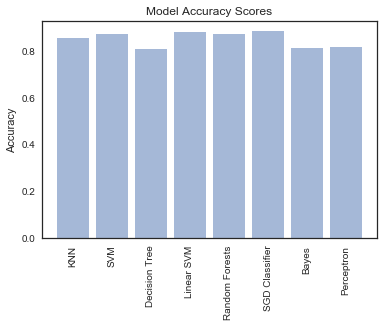

KNN 0.856123662307
SVM 0.872921615202
Decision Tree 0.796821793417
Linear SVM 0.883832335329
Random Forests 0.871581450654
SGD Classifier 0.873271889401
Bayes 0.806791569087
Perceptron 0.853754940711


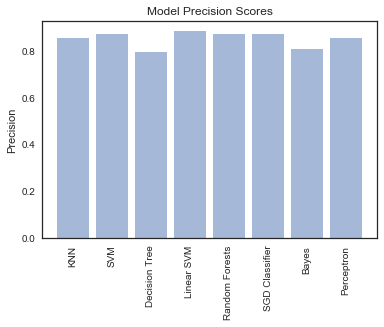

KNN 0.85308056872
SVM 0.870853080569
Decision Tree 0.831753554502
Linear SVM 0.874407582938
Random Forests 0.868483412322
SGD Classifier 0.898104265403
Bayes 0.8163507109
Perceptron 0.767772511848


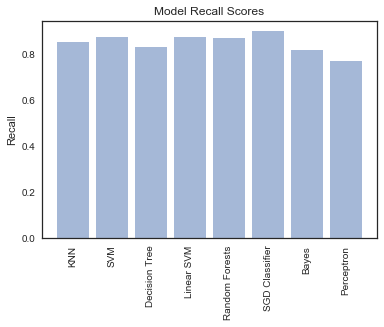

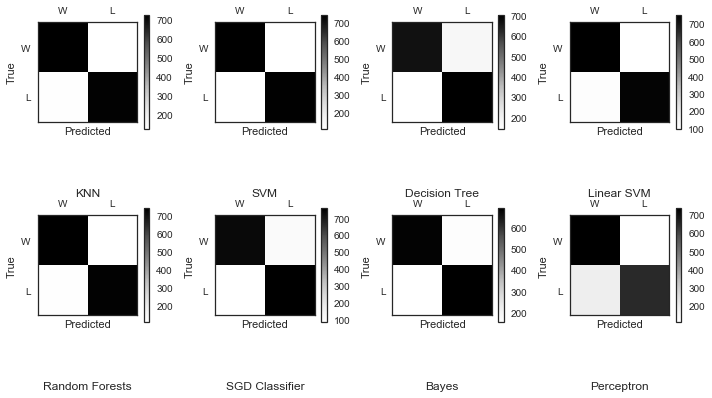

In [75]:
score_metrics = run_all_and_Plot(numerical_diffs[model_cols])
CompareAll = dict()
CompareAll['Baseline'] = score_metrics

for i in range(3):
    for key,val in score_metrics.items():
        print(str(key) +' '+ str(val[i]))
    plot_bar(score_metrics, i)
    
plot_cm(score_metrics)

KNN 0.515384615385
SVM 0.577777777778
Decision Tree 0.499145299145
Linear SVM 0.566666666667
Random Forests 0.548717948718
SGD Classifier 0.54188034188
Bayes 0.564102564103
Perceptron 0.532478632479


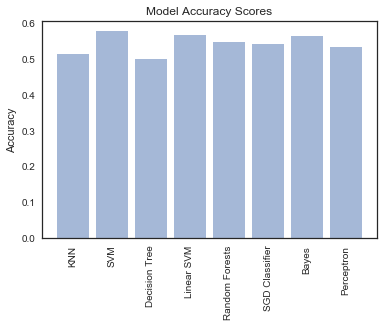

KNN 0.5024
SVM 0.561889250814
Decision Tree 0.485294117647
Linear SVM 0.553662691652
Random Forests 0.53488372093
SGD Classifier 0.60119047619
Bayes 0.552264808362
Perceptron 0.574193548387


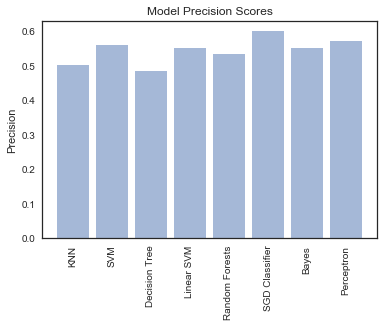

KNN 0.550877192982
SVM 0.605263157895
Decision Tree 0.463157894737
Linear SVM 0.570175438596
Random Forests 0.564912280702
SGD Classifier 0.177192982456
Bayes 0.556140350877
Perceptron 0.156140350877


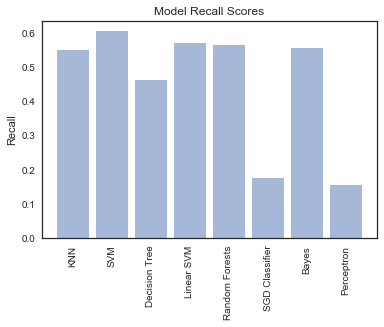

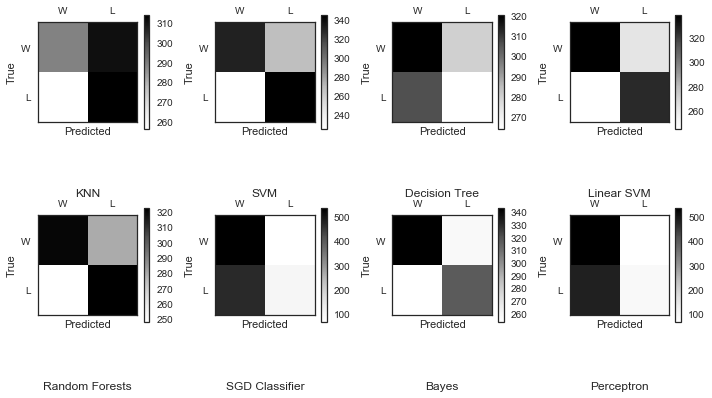

In [76]:
score_metrics = run_all_and_Plot(numerical_tally_diffs)
for i in range(3):
    for key,val in score_metrics.items():
        print(str(key) +' '+ str(val[i]))
    plot_bar(score_metrics, i)
plot_cm(score_metrics)

# Conclusion

This was an informative first step in understanding how different fight metrics impact the outcome of a UFC fight. The time series graphs helped me understand how fighting strategies have changed over time.  We can see that although BJJ practitioners had a significant advantage over other fighters early on, other fighters were eventually able to narrow that gap over time. The fighter rankings opened up different avenues to explore what separated top fighters from those on the other end of the spectrum.

The next step is to improve the future fight prediction algorithm. Currently, our models are able to judge the winner from past fights with 85-88% accuracy, but it is not quite able to predict the winner of future matchups. This may require different feature engineering or perhaps the incorporation of new features via a scraper rewrite. Currently the data that is fed into the algorithms is based on the difference in previous average metrics between two fighters. The reasoning was that if a fighter was outstriking or outgrapplint his or her opponent in the past, it may help us understand how they'd perform in the future. Unfortunately, this was not the case and yielded a peak accuracy of 58%. While disappointing, I'm confident that this can be improved through iteration.

There is still a lot that can be explored from this dataset. It would be interesting to understand what goes into a fight win streak or how to spot a bad matchup from a stylistic perspective. For now, however; I'm happy with the results. Initially, the model was able to judge the outcome with around 55-60% accuracy, but by  testing out different ideas and iterating on our process, we were able to achieve 88% accuracy. Progress will continue, but this feels like a good stopping point for now. Thanks for taking the time to read through this analysis.

# Stretch Goals

## Get Probability of a Win

Once this first part is done, it would be nice to calculate the probability that a fighter will win his/her next match.

# Scraper Rewrite

The fightmetric scraper reached completion a couple days ago with added functionality. Initially, I scraped the fights in one large chunk, but this had several drawbacks: it took hours to get any results, there was no way to tell whether it was pulling data properly and when it crashed, it resulted in a loss of all data (omg losing all progress after a script has been running for 3 hours is maddening!). The new iteration runs the scraper in chunks in a separate jupyter notebook. Each script processes 200 lines of fight urls and saves the results to separate CSVs. Enabled ```runtools``` in ```nbextensions``` to add the ```run all cells ignore errors``` option. This prevents the whole process from stoping if there's an error in one of the cells. This is a design principal I'm going to hold onto for future large projects because it prevents a lot of headaches.

## Revisions

The following features have been added/updated:

1. Date
2. Location
3. Title
4. Proper Name
5. Proper Win/Loss

## Bugs
1. Data is missing sometimes.
 1. Want to debug to determine why different runs yield different amounts of data
 2. Update: after fixing the name, last few runs have yielded a consistent number of rows (8774).

## Wish List
1. Details: This holds information on how the fight was finished (punches to head, neck crank, etc)
2. Weight class (from event page, useful for creating graphs)
3. Time: (how long the fight lasted)

# Ideas

1. Classifier for current fight is working. Need to re-think a way to get the prediction algorithm to work as well. Maybe getting more information on the fighters:
 1. Birth year
 2. Training camp
 3. Years training
 4. Background / specialty (boxing, wrestling bjj, etc)
2. Need to re-think how the data is fed into the prediction model. Doing tally differences is not currently working. Need to tweak that idea:
 1. Current trajectory?
 2. Only last few fights?
 3. Average fight statistics against other fighters?
  1. This would take the differences between their stats and opponents' stats in each previous fight and average them
3. Fight locations choropleth
4. Fighter network analysis